In [1]:
from __future__ import division
import sys,os
import time, datetime
import argparse
import h5py

import numpy as np
import matplotlib.pyplot as plt
from   matplotlib import cm

import pandas as pd
from   glob import glob

# %matplotlib notebook

## Import MKID libraries

In [2]:
## Load the modules
sys.path.insert(1, "/home/nexus-admin/NEXUS_RF/BackendTools")

import ResonanceFitter as fitres
import ResonanceFitResult as fitclass

import VNAMeas

import PyMKID_USRP_functions as puf
import MB_equations as MBe

## Runtime options

In [3]:
## Flag to display plots
show_plots = False

## Which powers to look at
pwr_min = -55
pwr_max = -15
pwr_stp =   5

## What's the temperature range
T_min =  10 
T_max = 350

## Define the set of powers we're interested in
power_range = np.arange(start=pwr_min, stop=pwr_max+pwr_stp, step=pwr_stp)
n_powers    = len(power_range)

## Set up global plot options

In [4]:
## Set up matplotlib options for plots
plt.rcParams['axes.grid'] = True
plt.rcParams.update({'font.size': 12})
#plt.rc('text', usetex=True)
plt.rc('font', family='serif')
dfc = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Temperature color scale
norm_T = plt.Normalize(vmin=T_min,vmax=T_max)
norm_P = plt.Normalize(vmin=pwr_min,vmax=pwr_max)

## Paths & file handling

In [5]:
## --- April 19, 2022 PT Scan Series ID --- ##

# day_max = '20220419'

## --- July 25-26, 2022 PT Scan Series ID --- ##

# ## - Way up
# day_min  = '20220725'
# time_min = '111503'

# day_max  = '20220725'
# time_max = '175630'

# ## - Way down
# day_min  = '20220725'
# time_min = '180911'

# day_max  = '20220726'
# time_max = '062506'

## --- Feb 24-25, 2023 PT Scan Series ID --- ##

# ## - Way up
day_min  = '20230224'
time_min = '075000'

day_max  = '20230224'
time_max = '183600'
rmv_0224 = ["20230224_101505","20230224_102040"]

# ## - Way down
# day_min  = '20230224'
# time_min = '183600'

# day_max  = '20230225'
# time_max = '075000'

## Path to VNA data
dataPath = '/data/TempSweeps/VNA/'

## Create a place to store processed output
# out_path = '/data/ProcessedOutputs/out_' + series

## Method to pull all files for a given RF power

In [6]:
def get_input_files_all(day, pwr, verbose=False):

    ## Get all folders in date
    datePath    = os.path.join(dataPath, day)

    ## Define the series path from the series
    srPath = os.path.join(datePath, "*_*")

    ## File string format
    fn_form = ("TPsweep_T*_P%i" % pwr) + "_*.h5"

    ## Find and sort the relevant directories in the series
    if (verbose):
        print("Searching for files in:", srPath)
        print(" with form:", fn_form)
    vna_file_list = glob(os.path.join(srPath,fn_form))
    vna_file_list.sort(key=os.path.getmtime)
    if (verbose):
        print("Using files:")
        for fname in vna_file_list:
            print("-",fname)
    return np.array(vna_file_list)

In [7]:
def dt_from_fname(fname):
    ## Remove the extension
    fname = fname.split("/")[-1].split(".")[-2]
    
    ## Grab the date and time strings
    dtstr = fname.split("_")[-2:]
    
    ## Parse those strings into a datetime object
    ts    = datetime.datetime( int(dtstr[0][0:4]) , int(dtstr[0][4:6]) , int(dtstr[0][6:8]) ,
                               int(dtstr[1][0:2]) , int(dtstr[1][2:4]) , int(dtstr[1][4:6]) )
    return ts

In [8]:
def get_input_files_range(day_min, time_min, day_max, time_max, pwr, remove=None, verbose=False):
    
    ts_min = datetime.datetime( int(str( day_min)[0:4]) , int(str( day_min)[4:6]) , int(str( day_min)[6:8]) ,
                                int(str(time_min)[0:2]) , int(str(time_min)[2:4]) , int(str(time_min)[4:6]) )
    
    ts_max = datetime.datetime( int(str( day_max)[0:4]) , int(str( day_max)[4:6]) , int(str( day_max)[6:8]) ,
                                int(str(time_max)[0:2]) , int(str(time_max)[2:4]) , int(str(time_max)[4:6]) )
    
    all_fs = get_input_files_all(day_min, pwr, verbose=False)
    
    all_dt = np.vectorize(dt_from_fname)(all_fs)
    
    indexr = (all_dt >= ts_min) * (all_dt <= ts_max)
    
    trim_fs = all_fs[indexr]
    n_files = len(trim_fs)
    
    if remove is not None:
        for j in np.arange(len(remove)):
            for k in np.arange(len(trim_fs)):
                if k>=n_files:
                    break
                if remove[j] in trim_fs[k]:
                    if verbose:
                        print("Removing run:",remove[j] )
                    trim_fs=np.append(trim_fs[:k-1],trim_fs[k:])
                    n_files=n_files-1
    
    if verbose:
        print("Using files:")
        print(trim_fs)
    
    return trim_fs

## Outer Loop
Loop over each RF stimulus power, get the S21 vs F data for each T, fit to MB equations, store fit data. Need to separate out Al vs Nb 7 resonators.

In [9]:
resonator = "Al" ## "Al" or Nb7"
idx  = 0 if resonator=="Al" else 1
# resf = 4.242182 if resonator=="Al" else 4.244763
resf = 4.241985 if resonator=="Al" else 4.244565
power_to_plot = -30

## Resonance plot

<IPython.core.display.Javascript object>


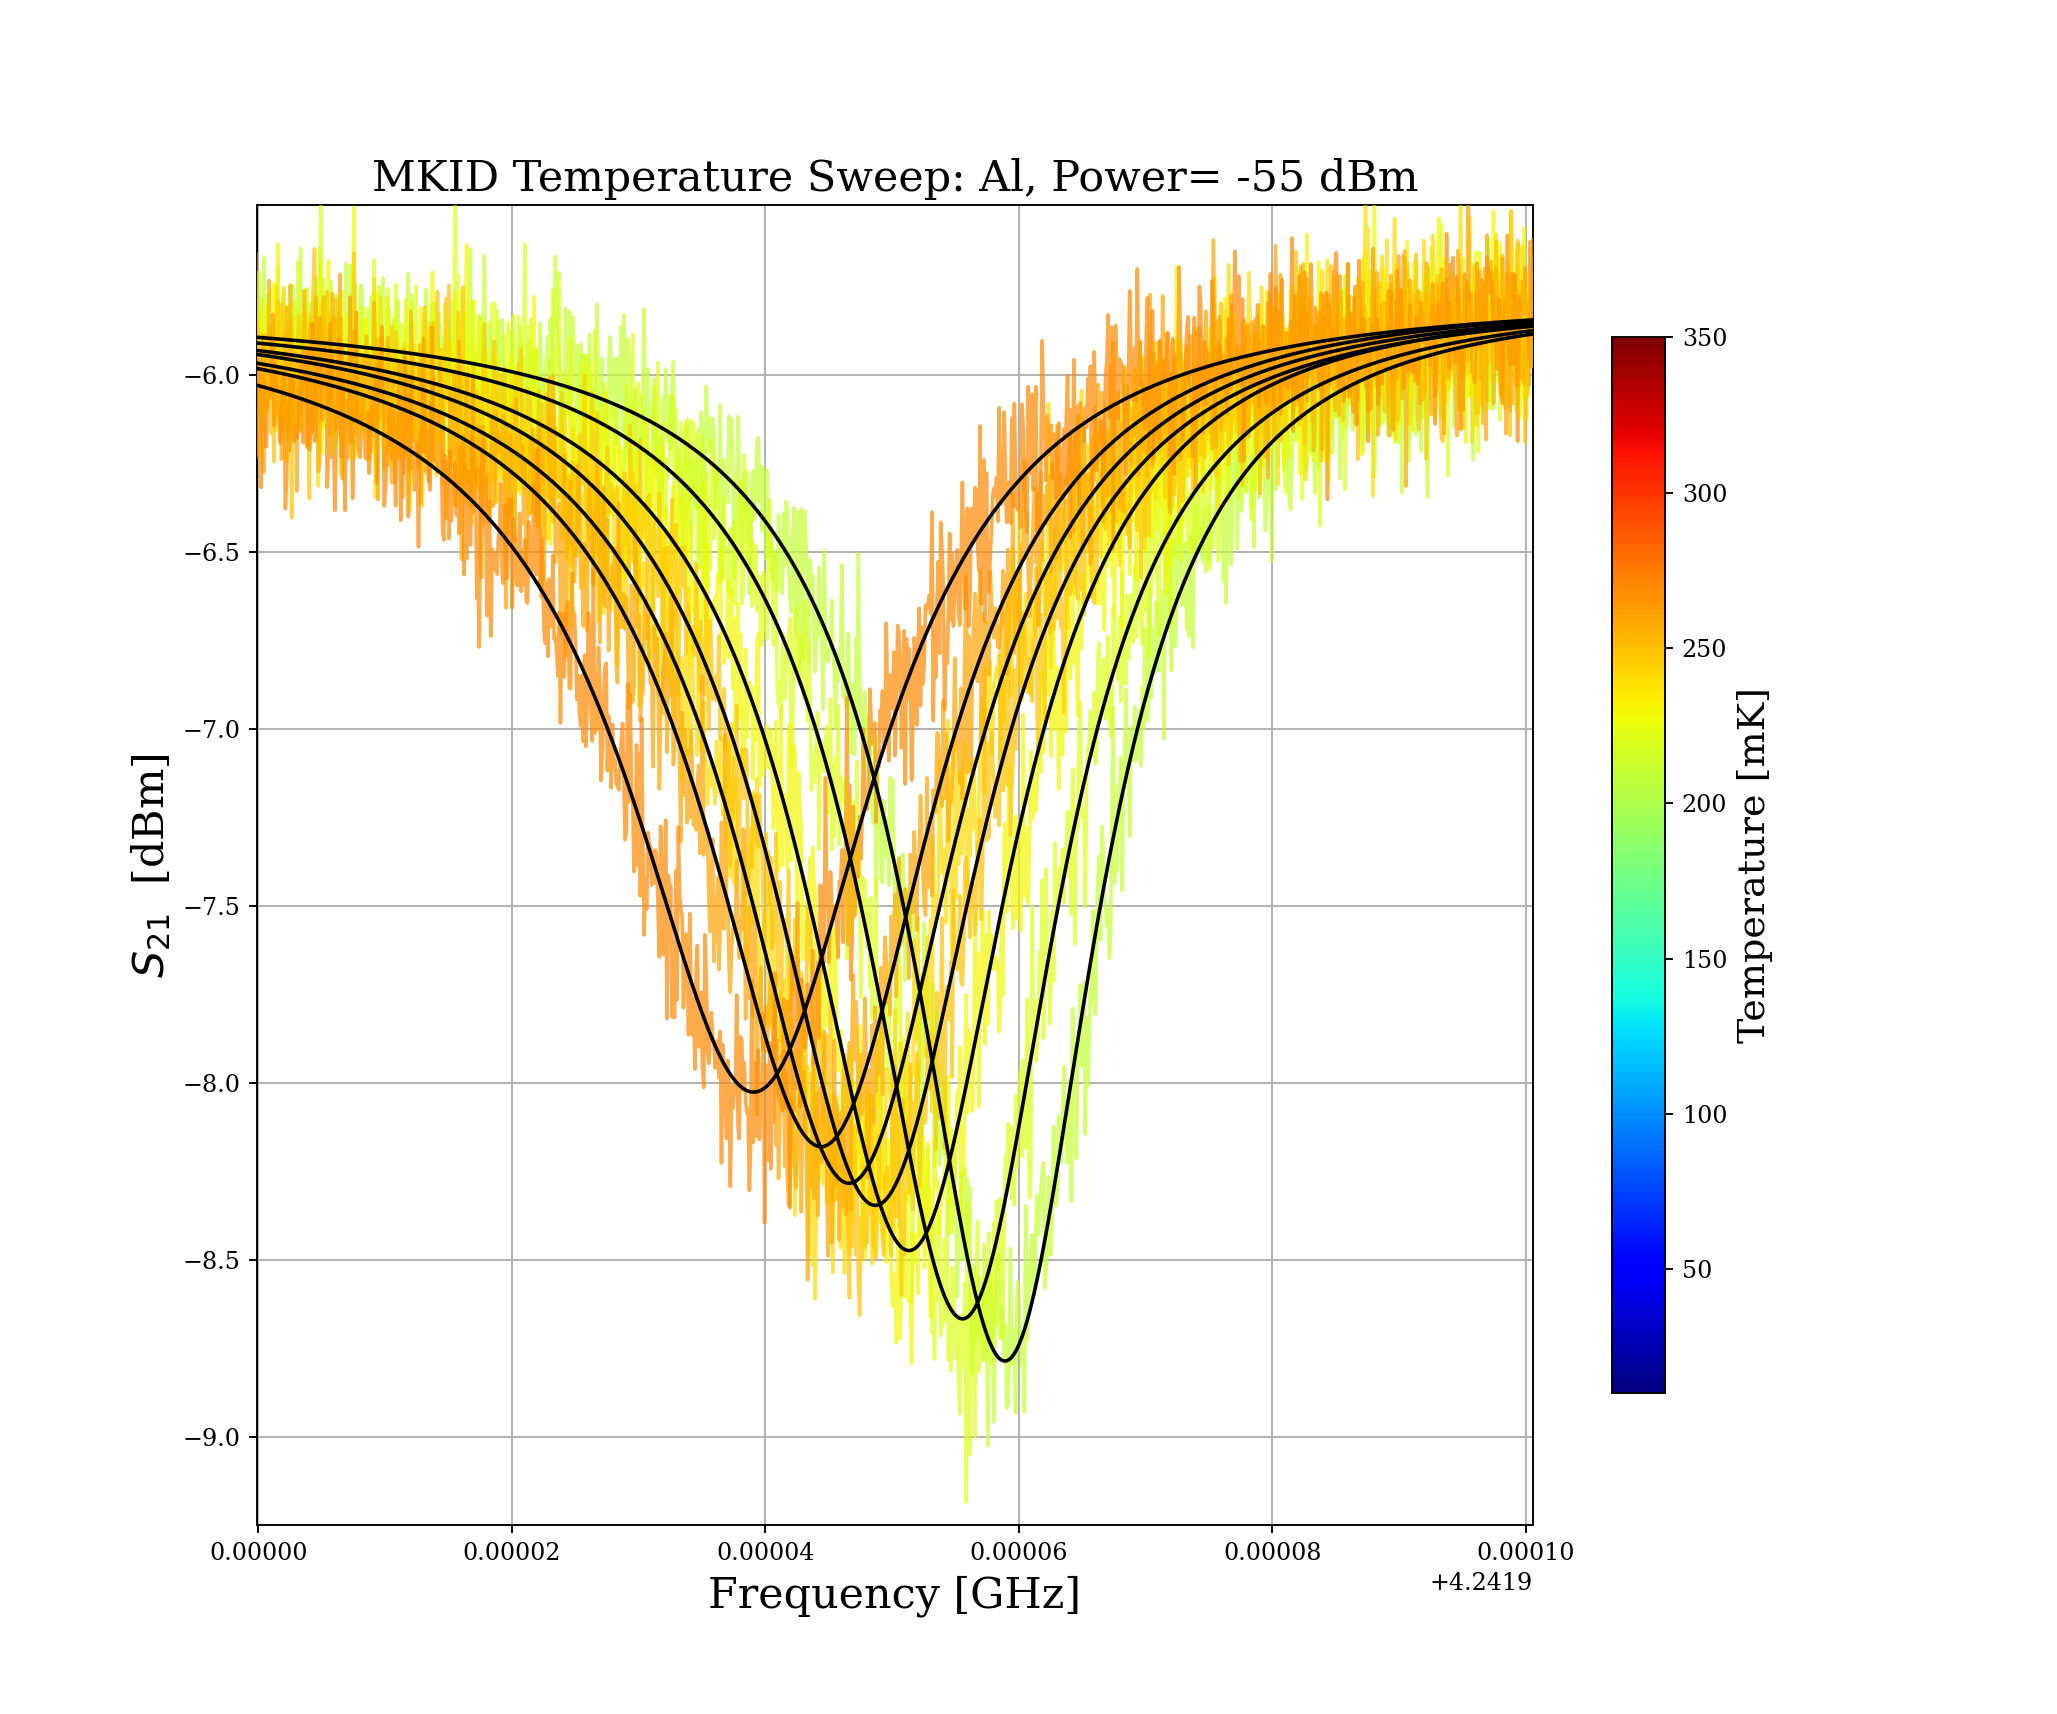

Resonance #0
Resonance #1


/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(

Resonance #0
Resonance #0


/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Resonance #0
Resonance #1
Resonance #2


/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Resonance #0
Resonance #1


/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Resonance #0
Resonance #1
Resonance #2
Resonance #3
Resonance #0


/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Resonance #1
Resonance #2
Resonance #3
Resonance #4


/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


<IPython.core.display.Javascript object>


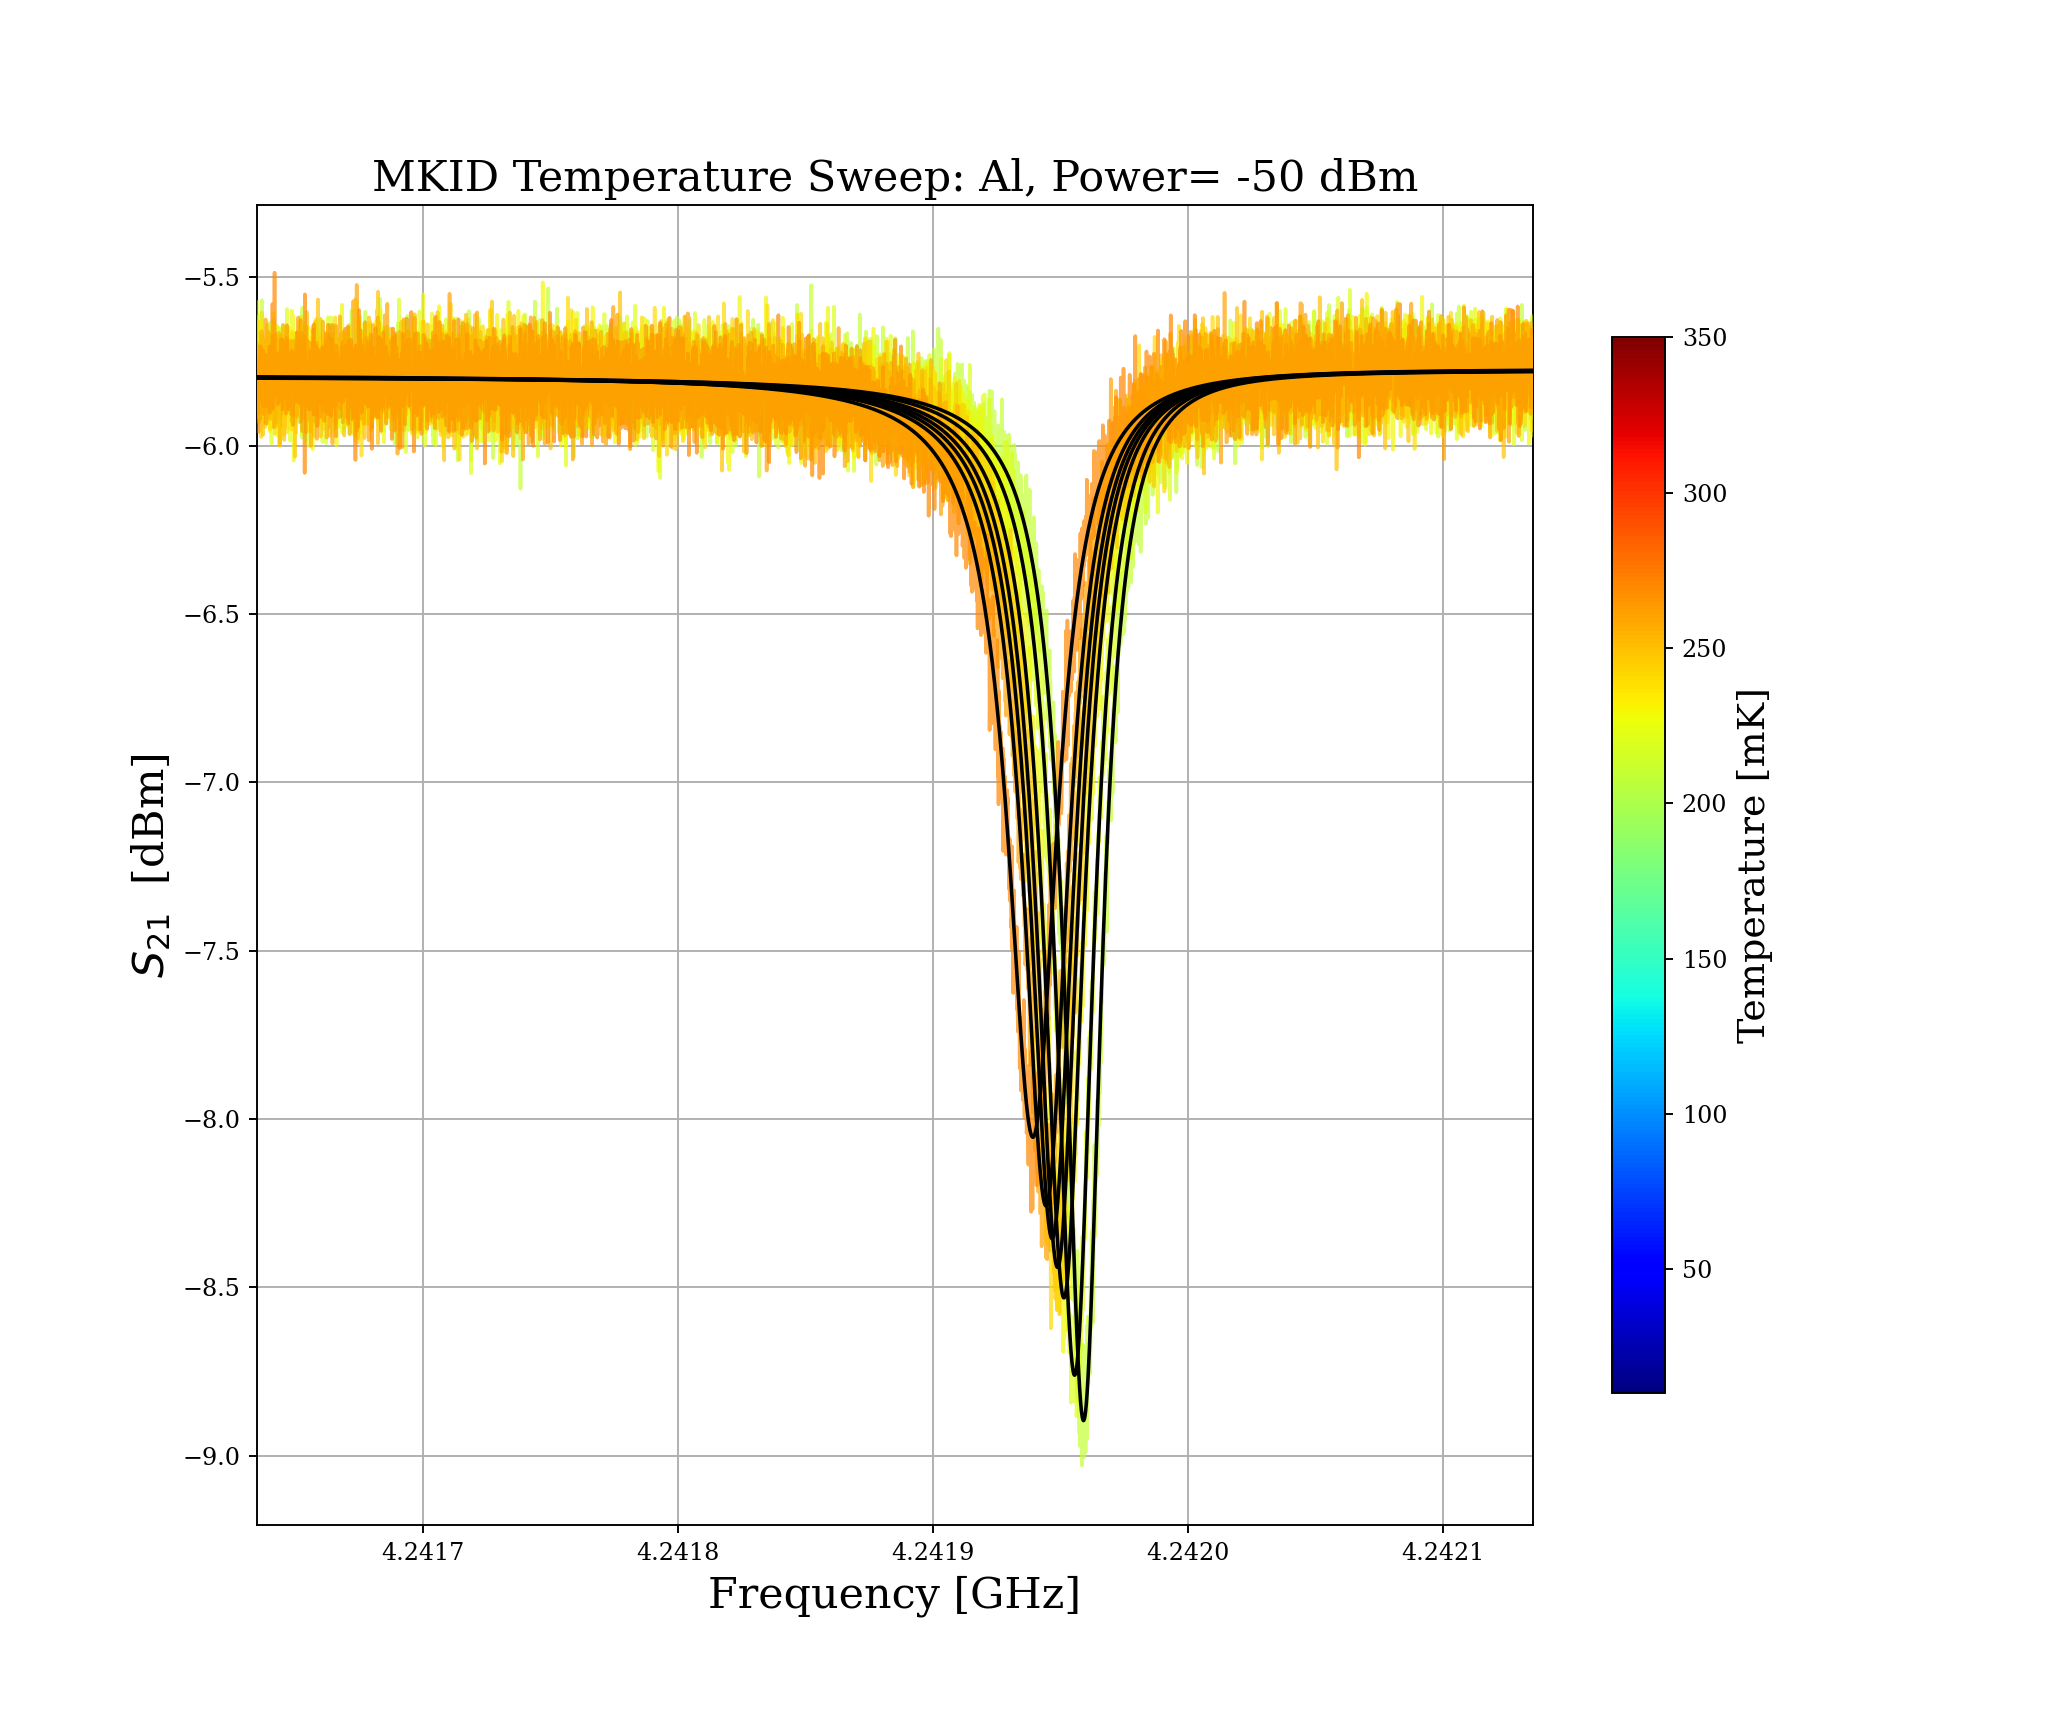

Resonance #0
Resonance #0


/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(

Resonance #0
Resonance #0


/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(

Resonance #0
Resonance #0


/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(

Resonance #0


/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


<IPython.core.display.Javascript object>


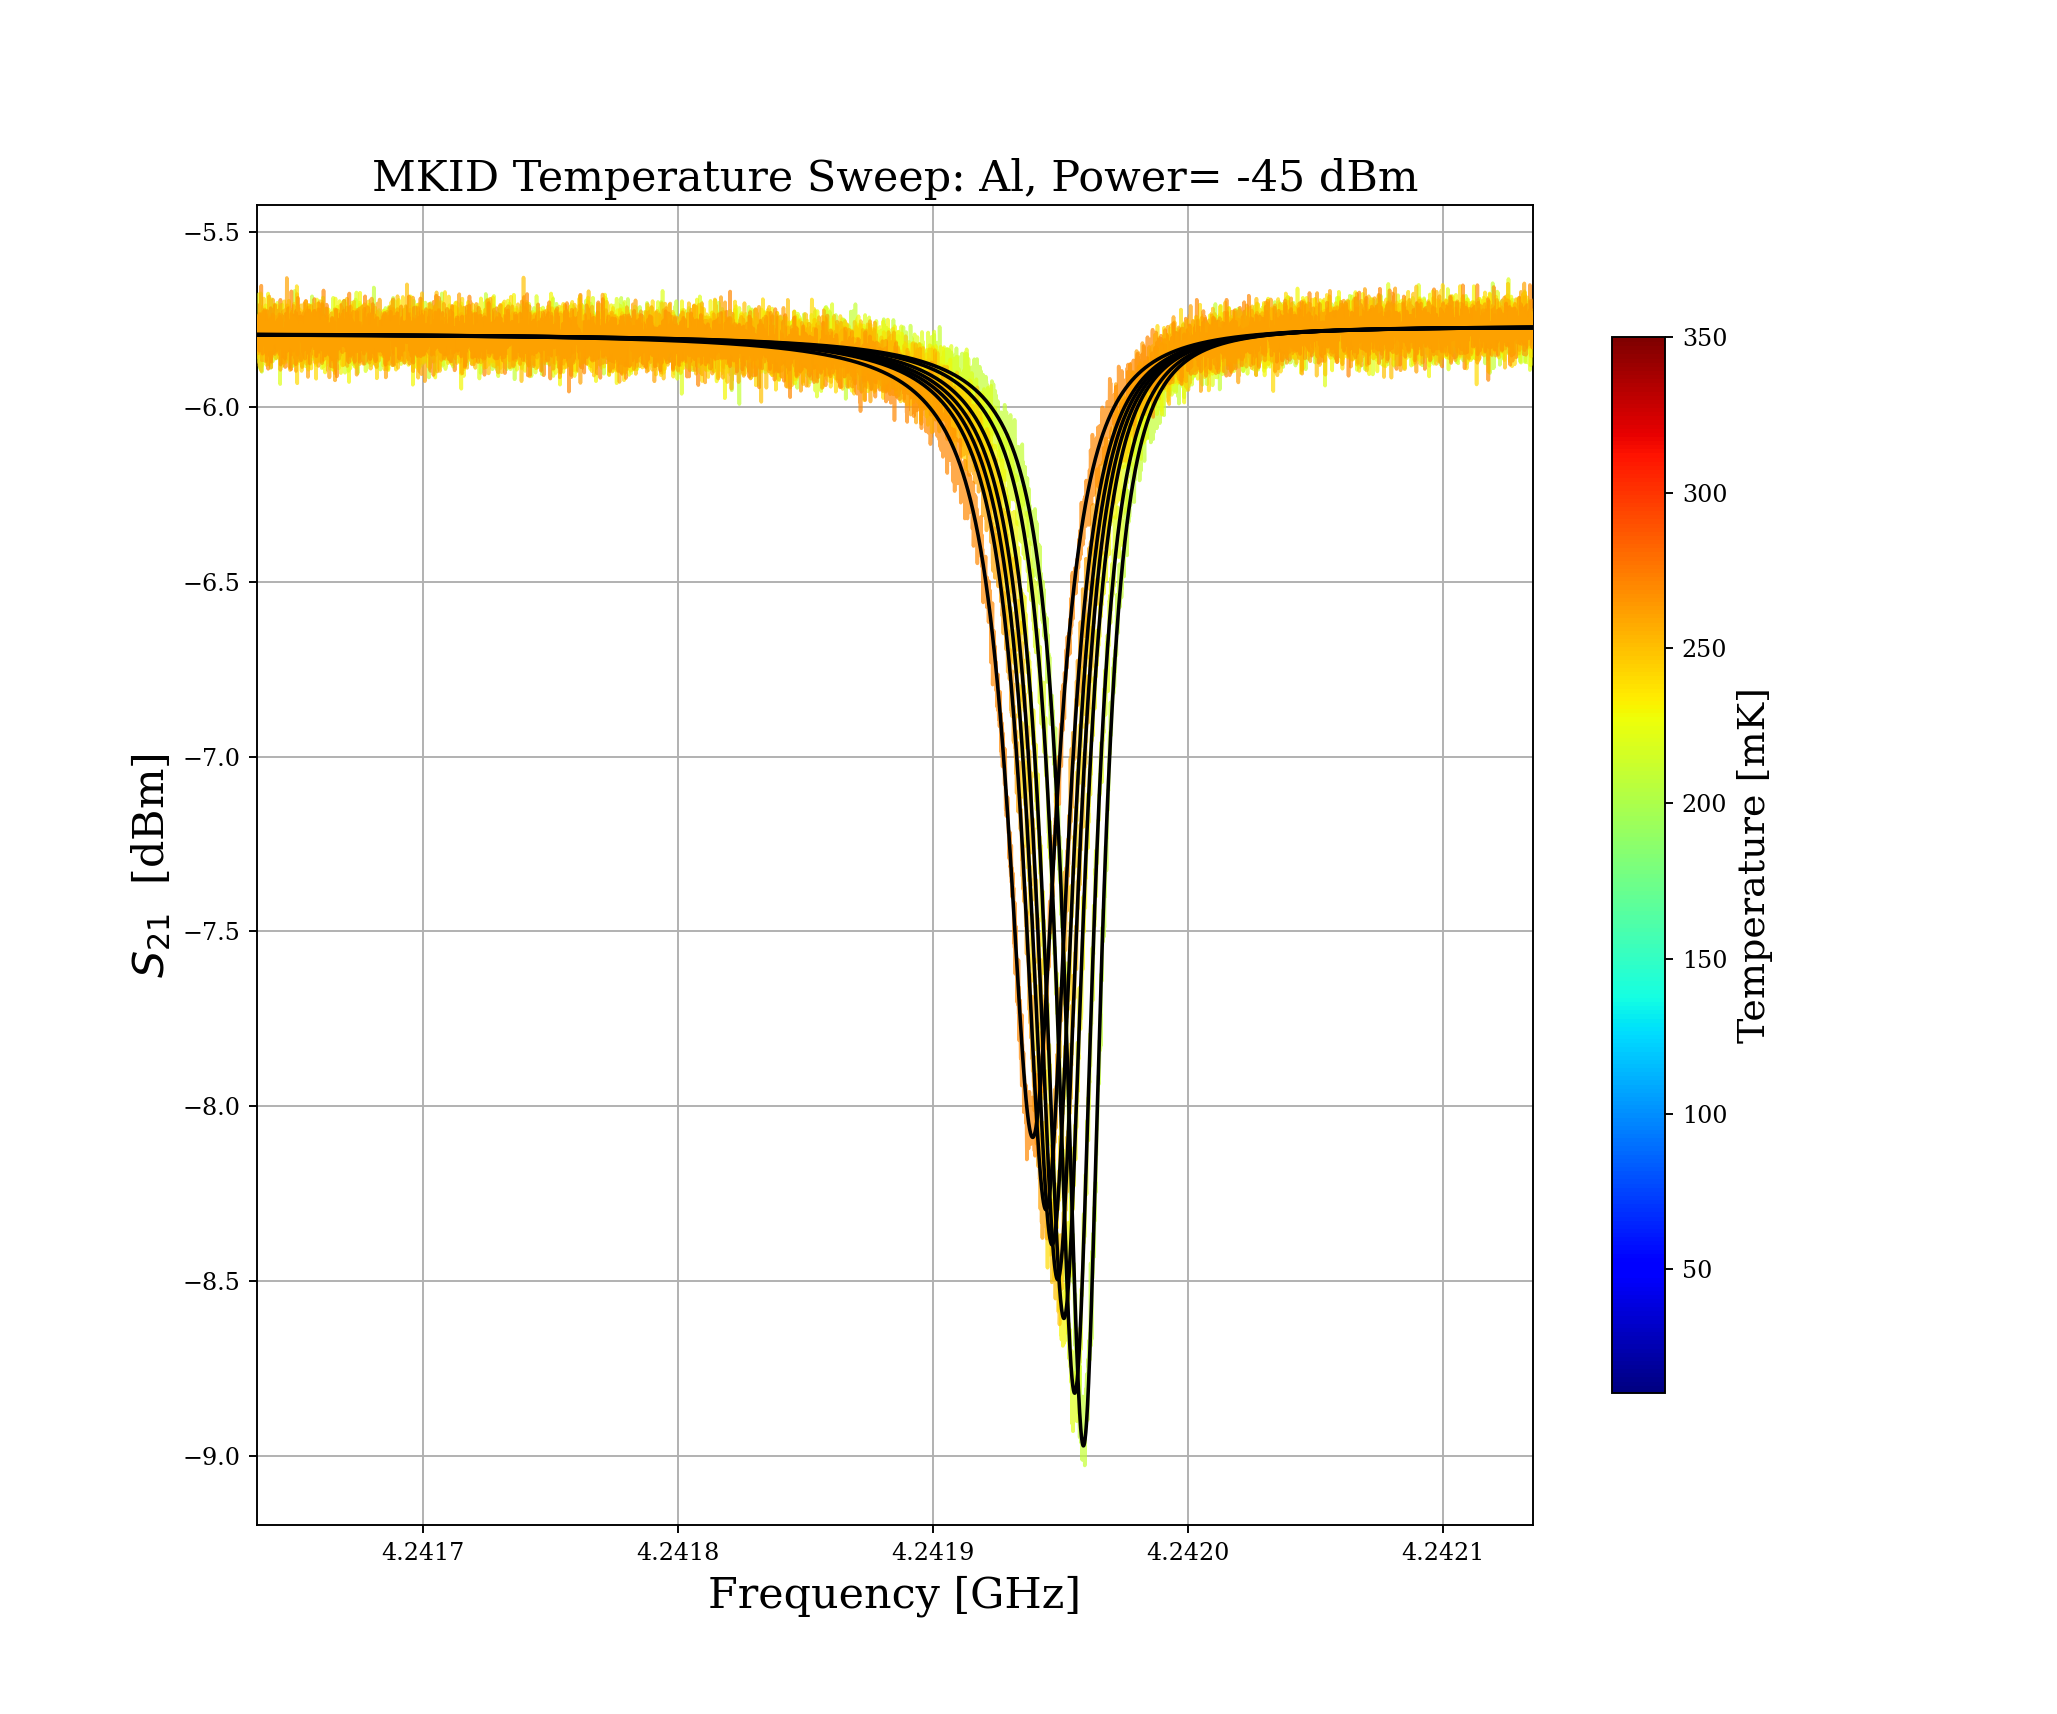

Resonance #0
Resonance #0


/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(

Resonance #0
Resonance #0


/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(

Resonance #0
Resonance #0


/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(

Resonance #0


/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


<IPython.core.display.Javascript object>


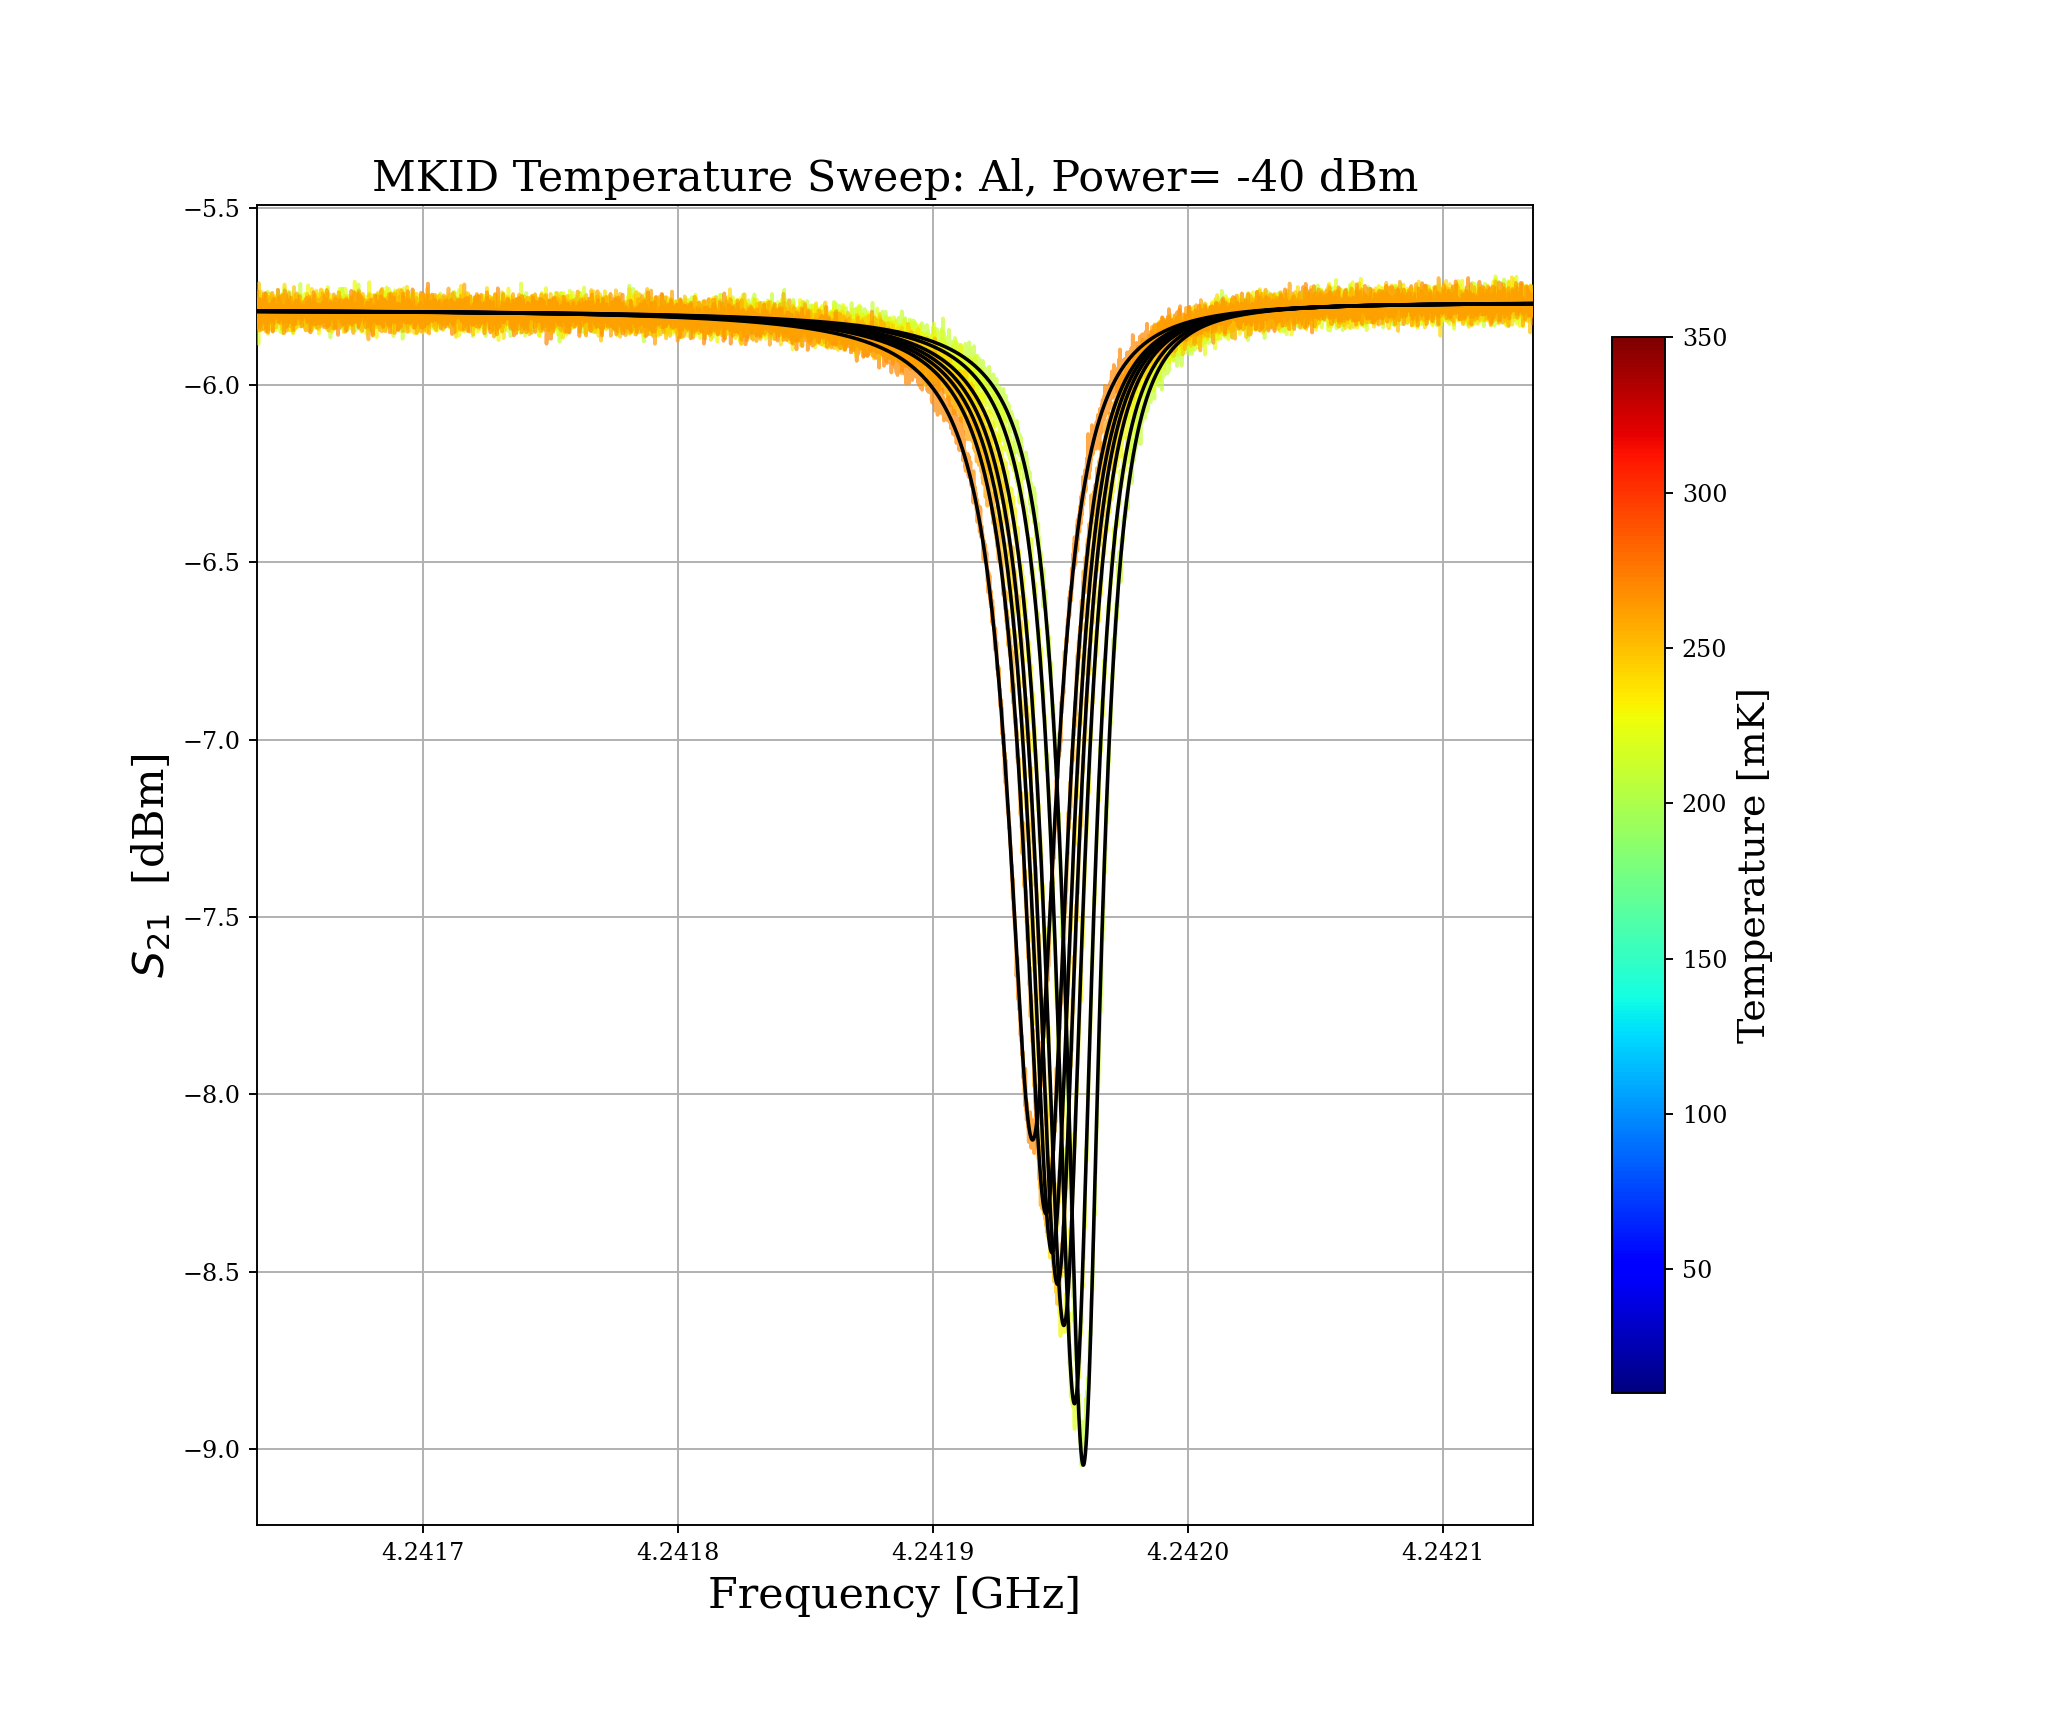

Resonance #0
Resonance #0


/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(

Resonance #0
Resonance #0


/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(

Resonance #0
Resonance #0


/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(

Resonance #0


/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


<IPython.core.display.Javascript object>


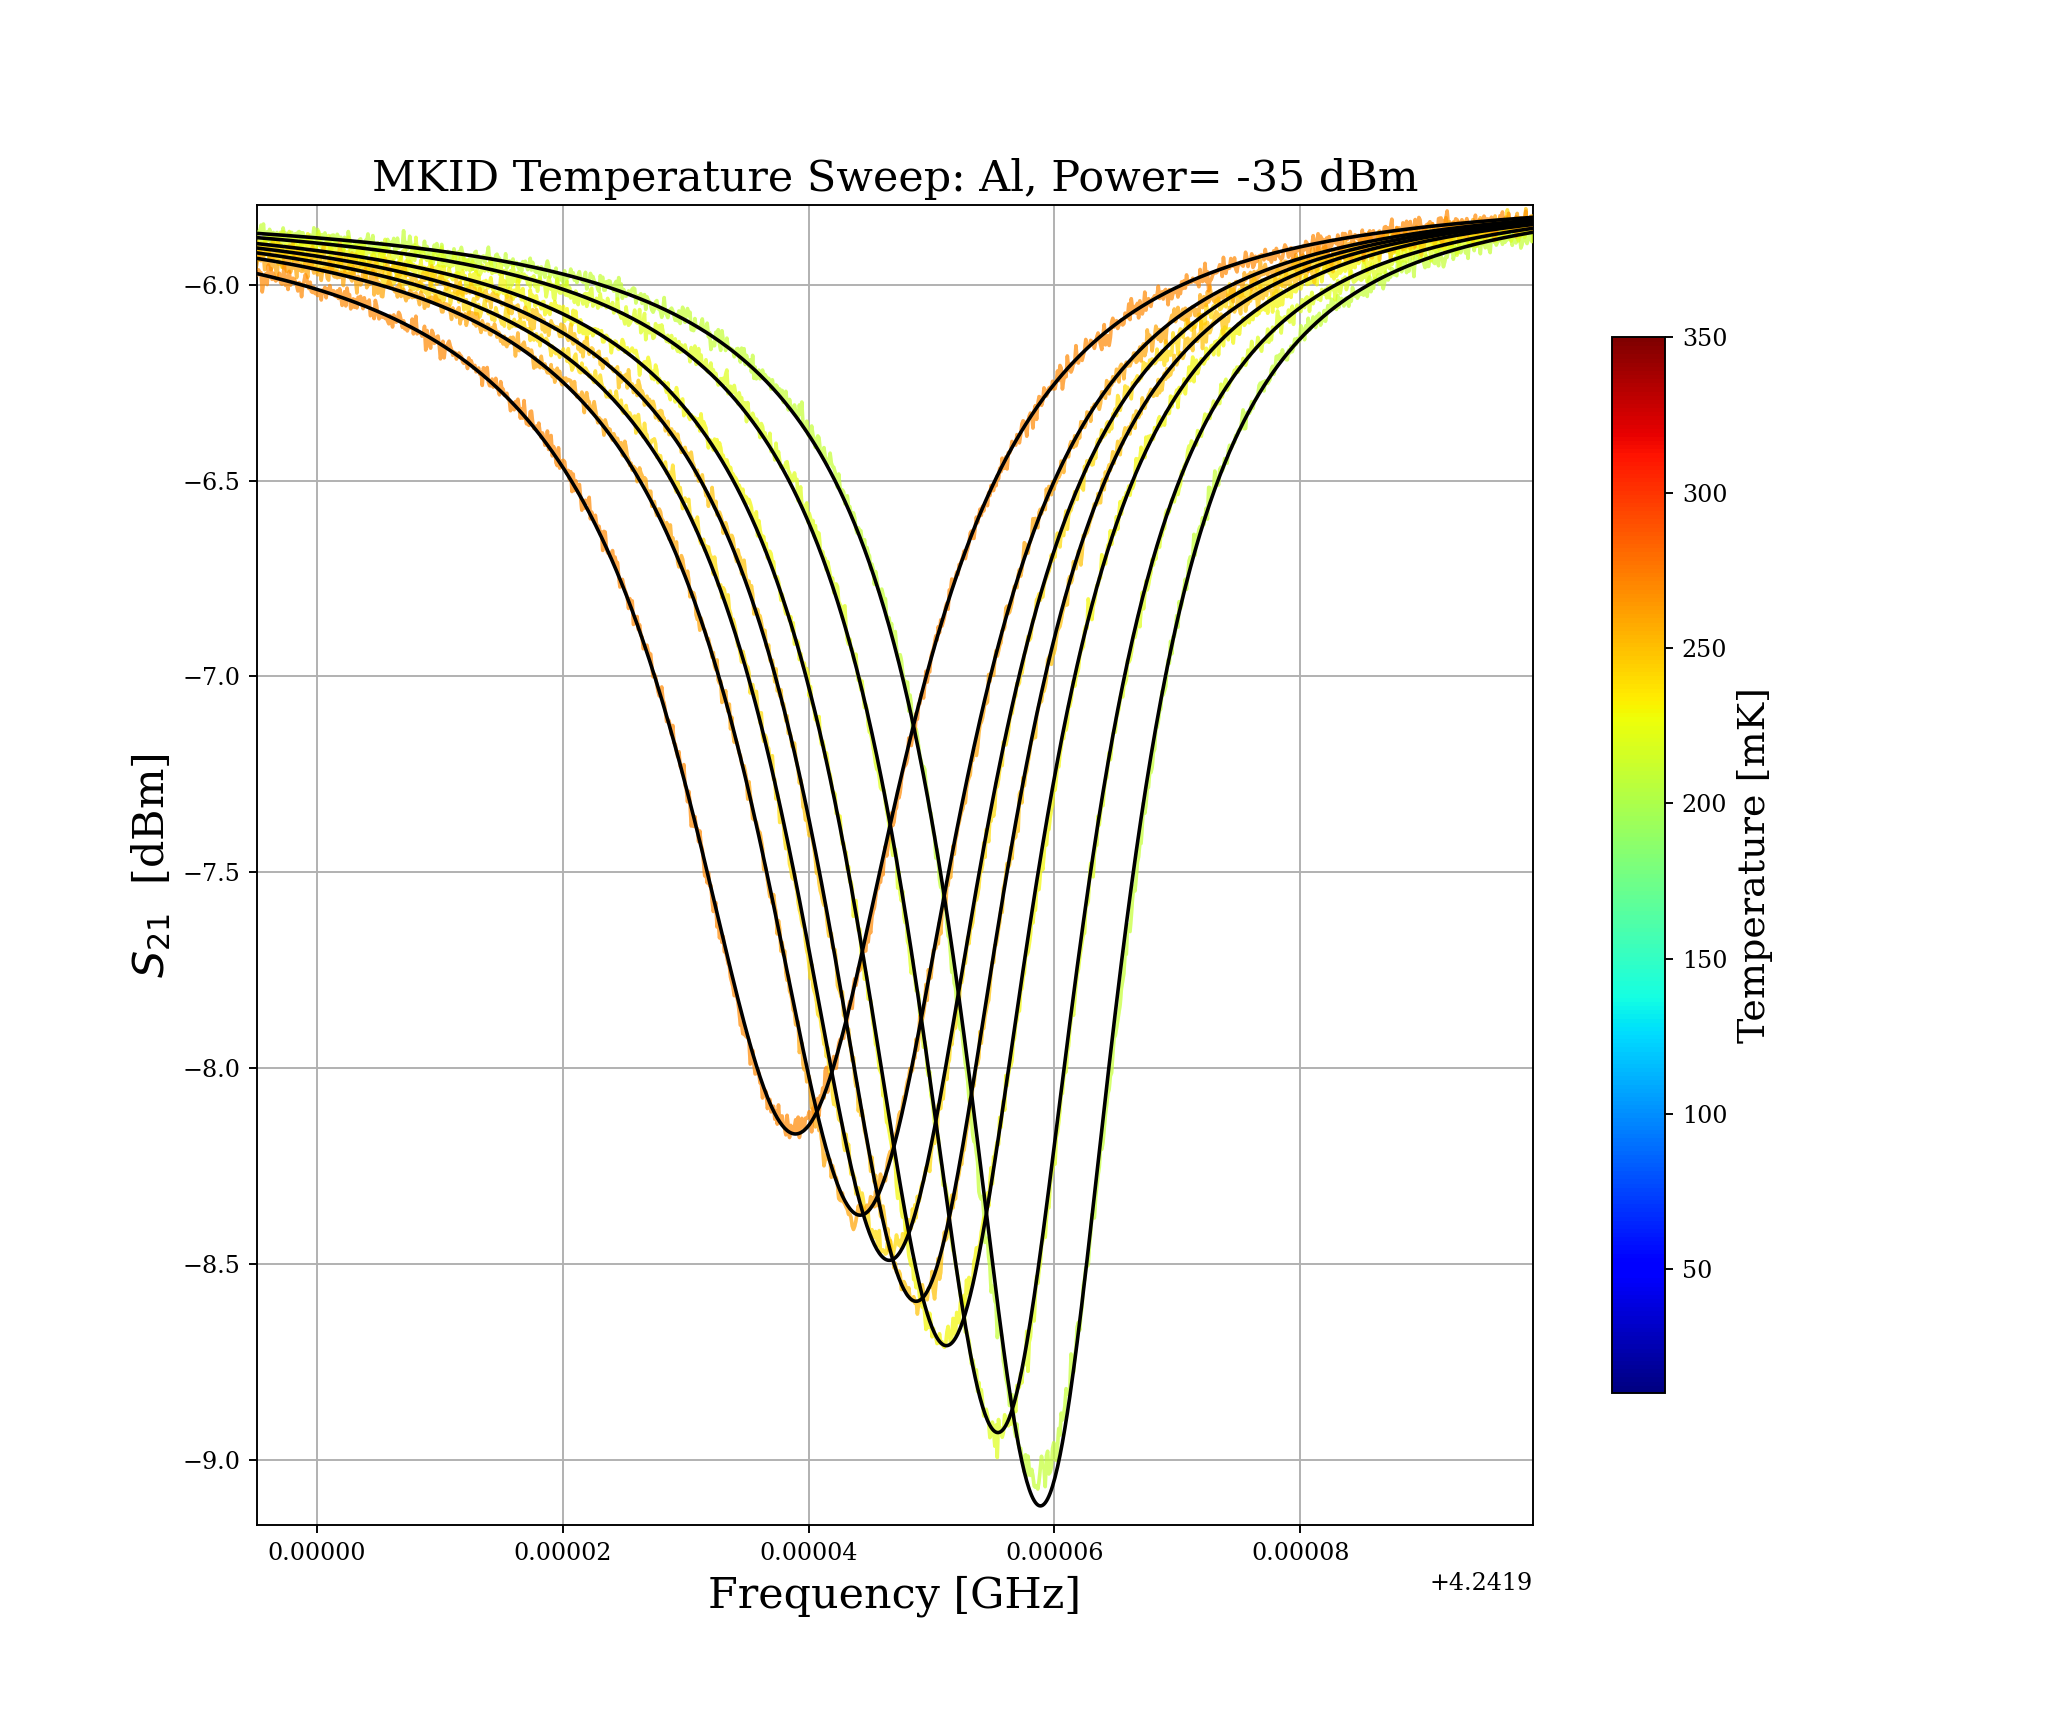

Resonance #0
Resonance #0


/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(

Resonance #0
Resonance #0


/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(

Resonance #0
Resonance #0


/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(

Resonance #0


/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


<IPython.core.display.Javascript object>


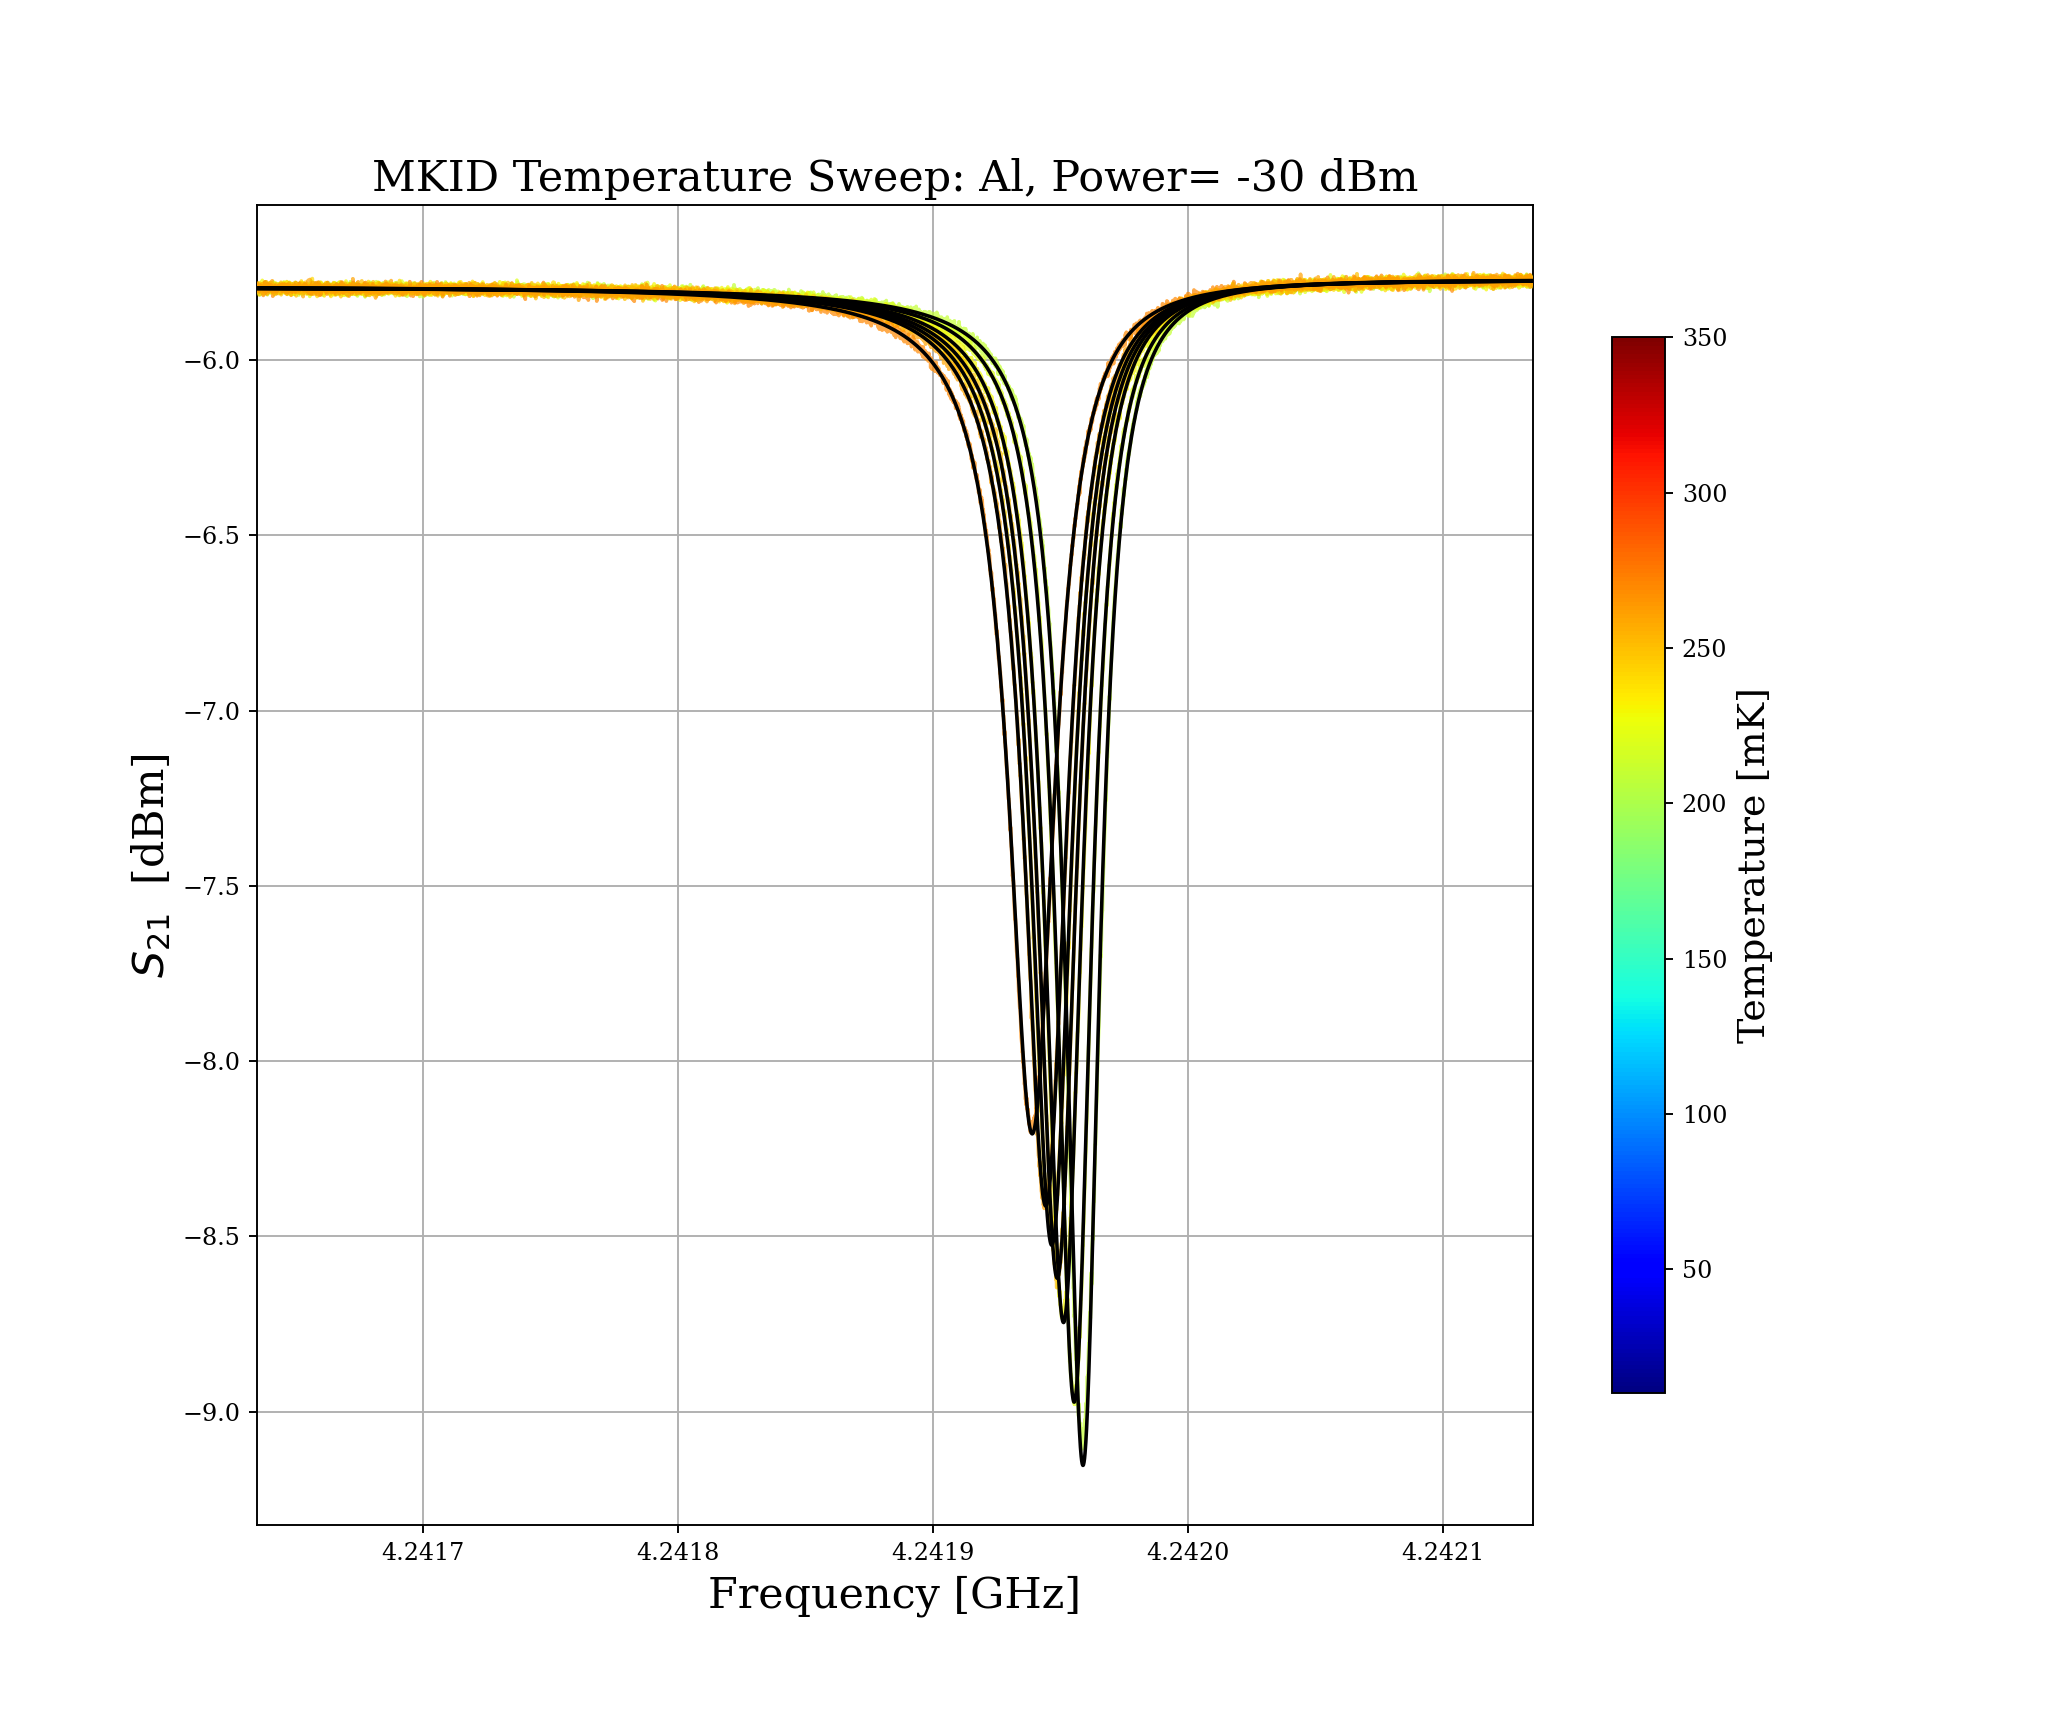

Resonance #0
Resonance #0


/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(

Resonance #0
Resonance #0


/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(

Resonance #0
Resonance #0


/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(

Resonance #0


/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


<IPython.core.display.Javascript object>


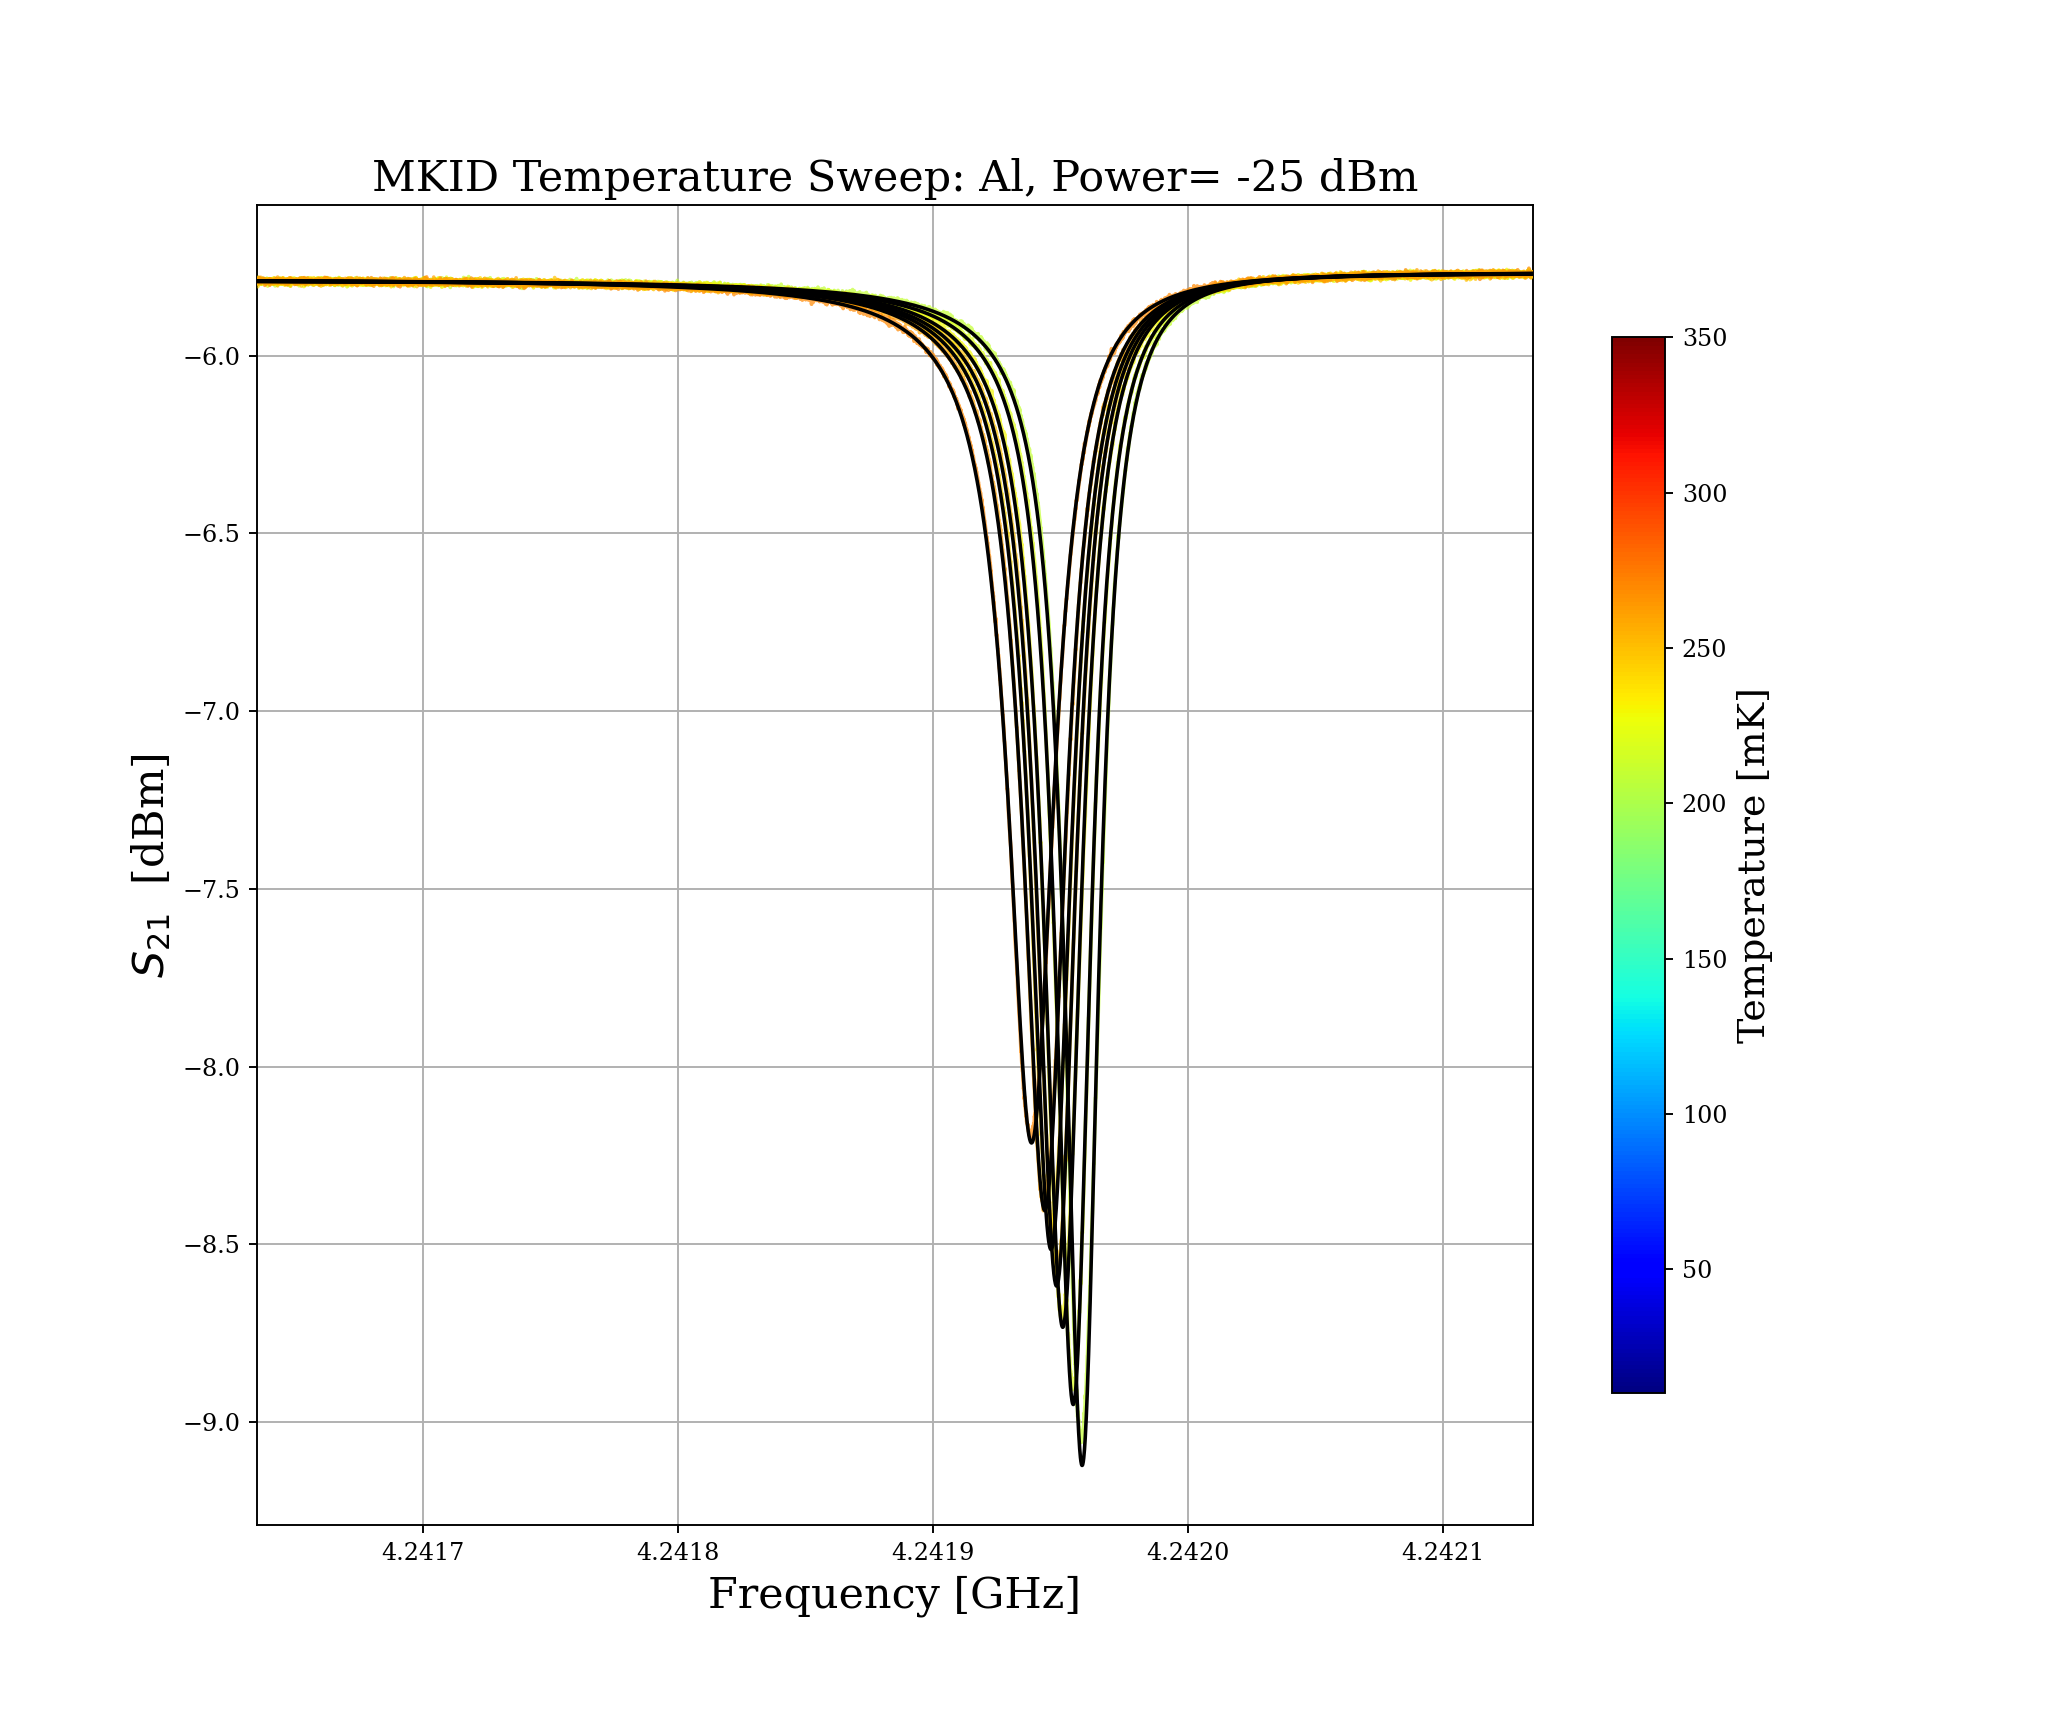

Resonance #0
Resonance #0


/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(

Resonance #0


/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(

Resonance #0
Resonance #0
Resonance #0


/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(

Resonance #0


/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


<IPython.core.display.Javascript object>


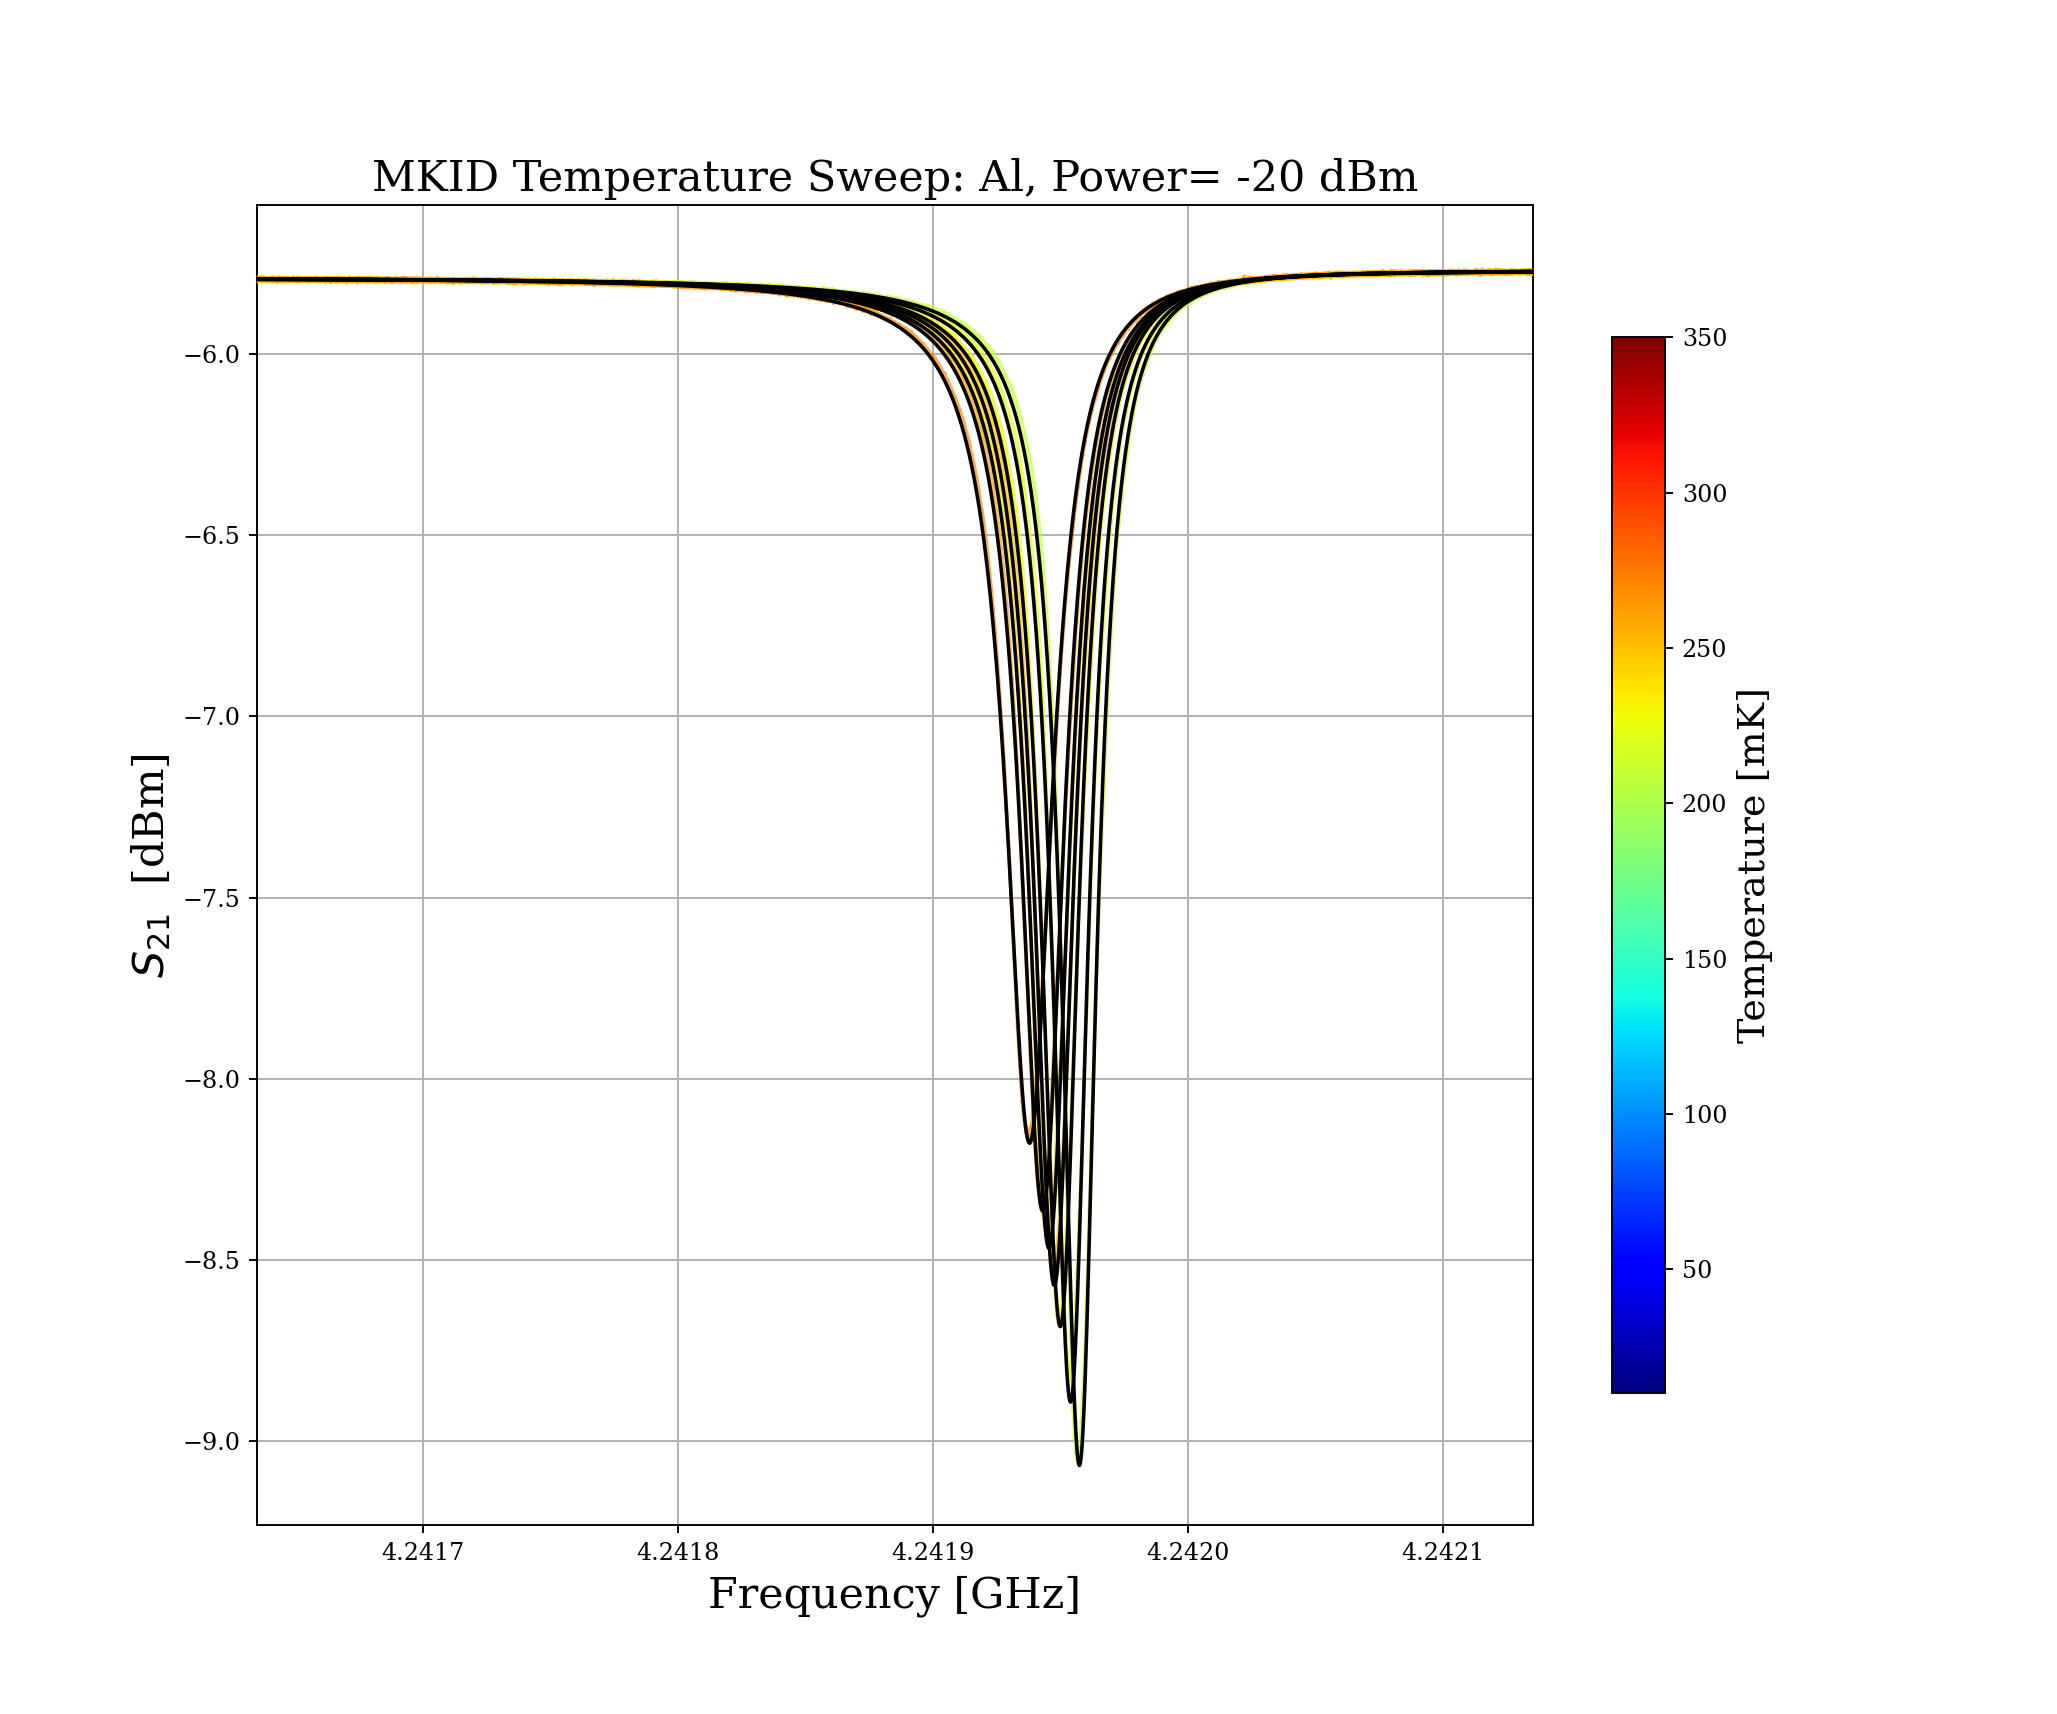

Resonance #0
Resonance #0


/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(

Resonance #0
Resonance #0


/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(

Resonance #0
Resonance #0


/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(

Resonance #0


/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


<IPython.core.display.Javascript object>


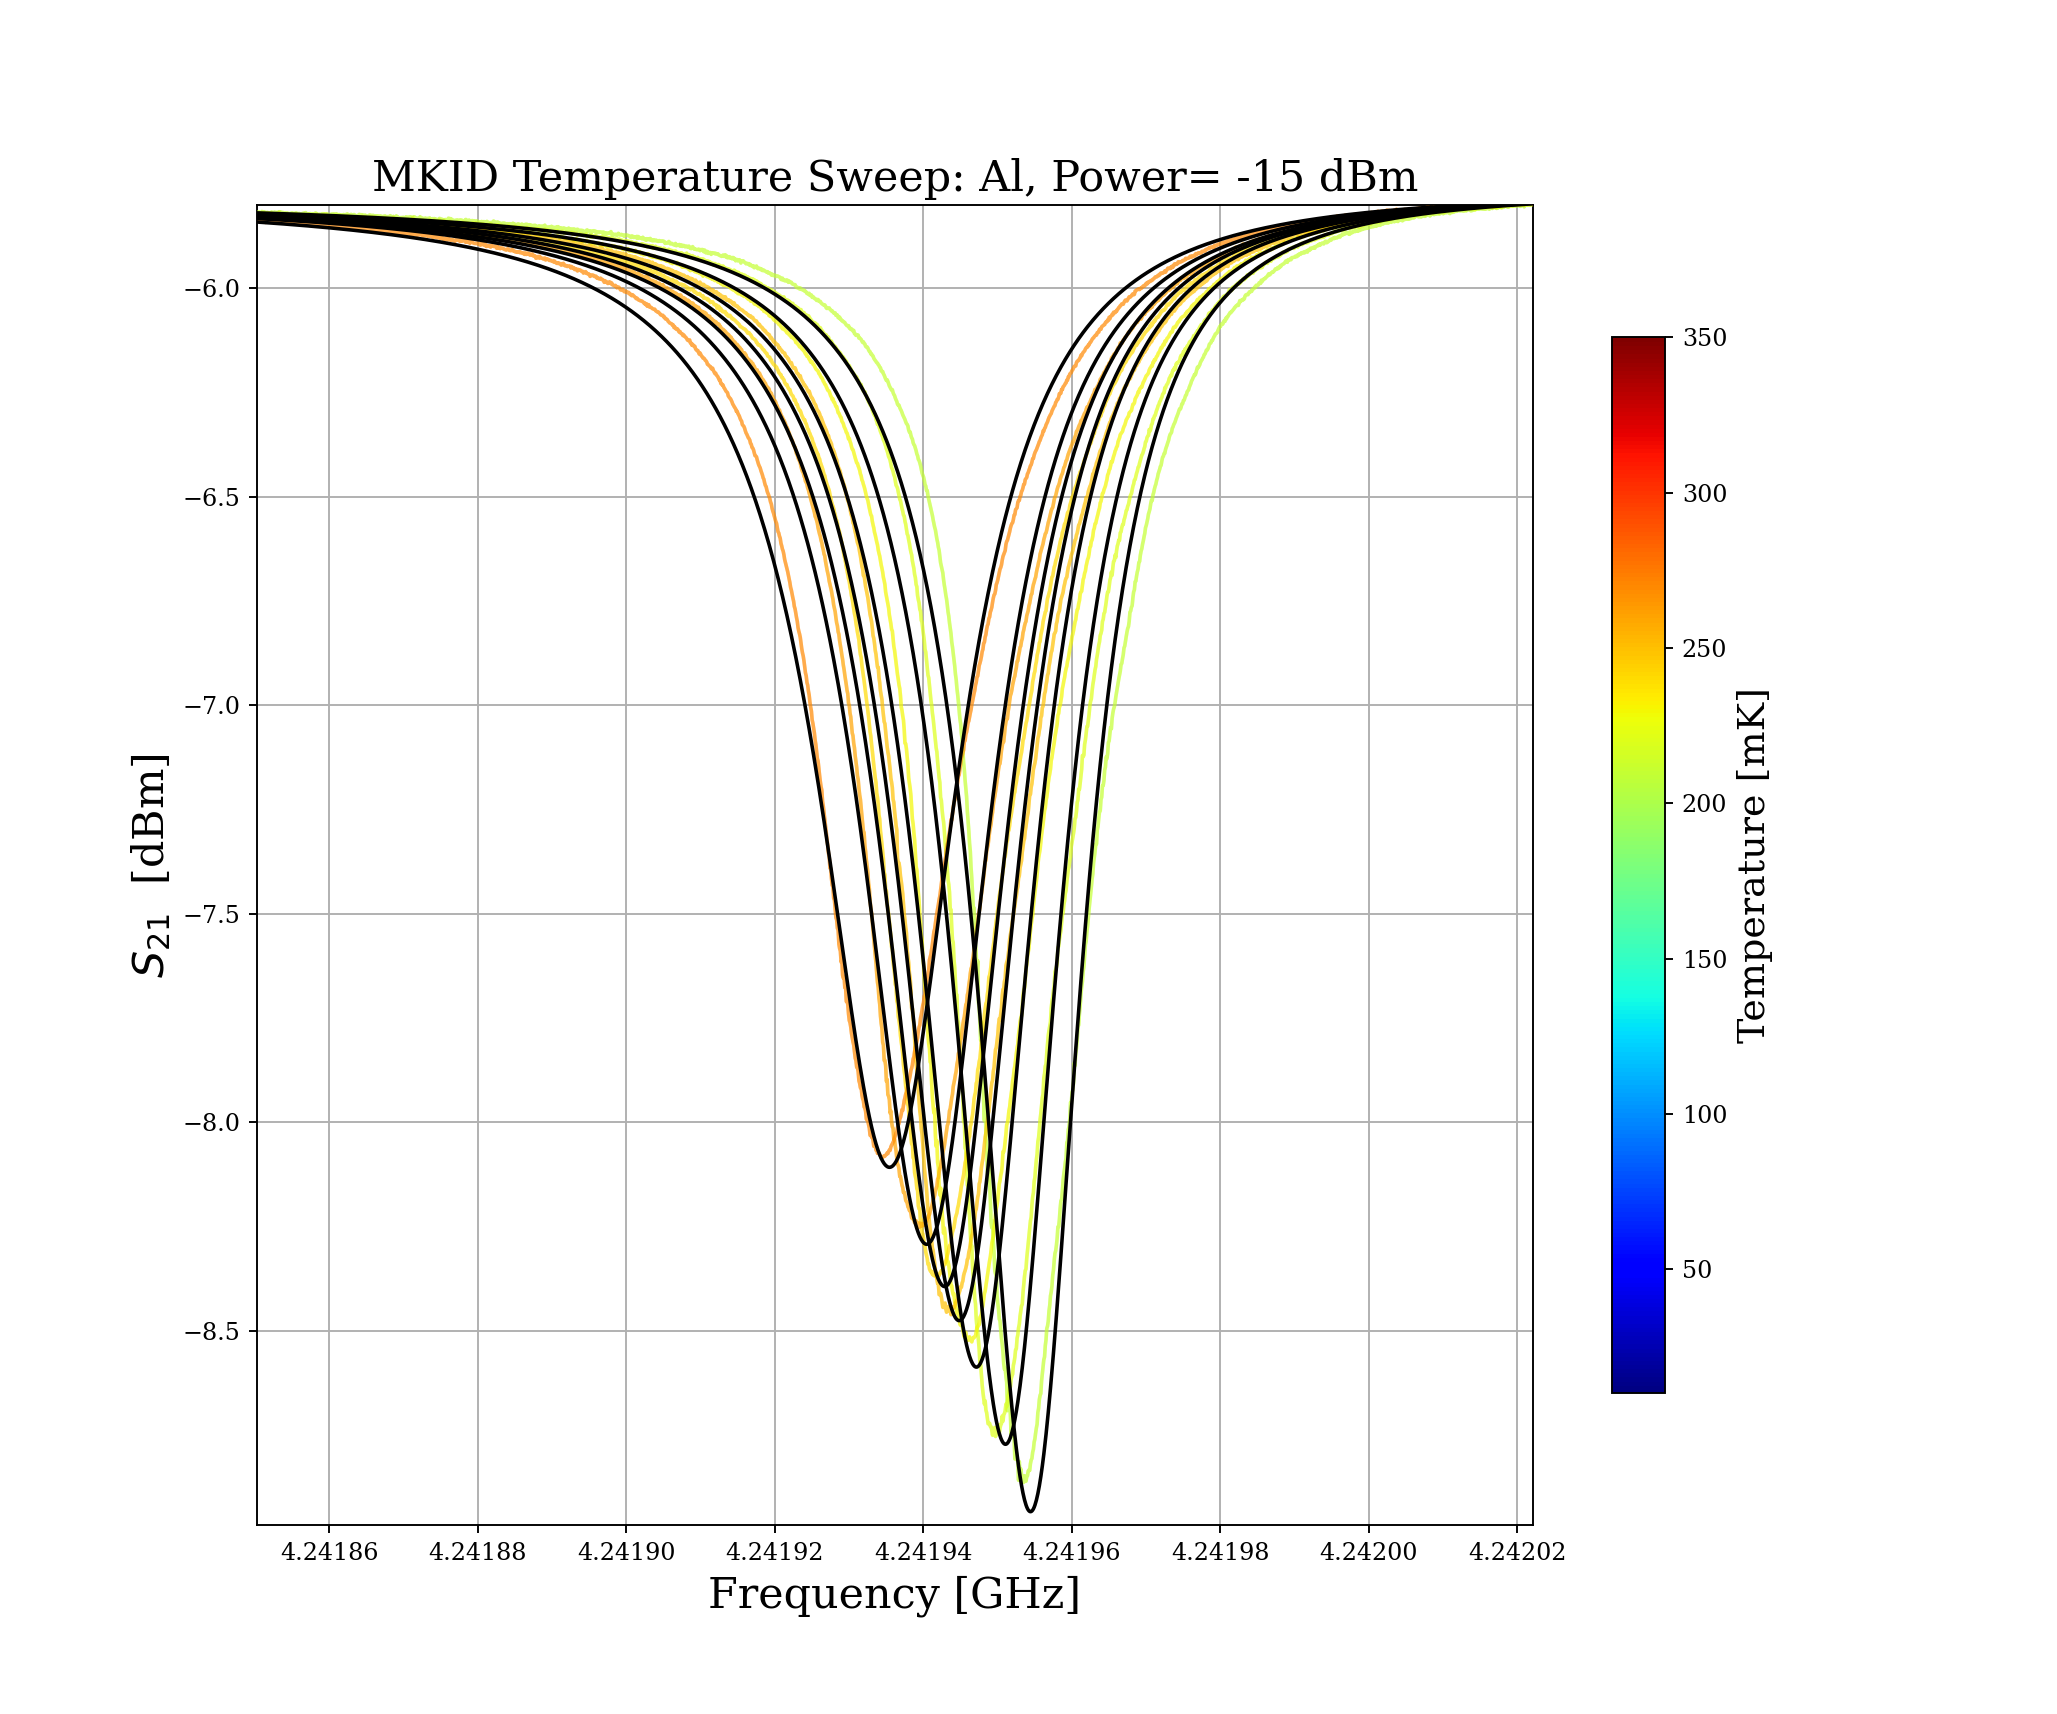

Resonance #0
Resonance #0


/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(

Resonance #0
Resonance #0


/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(

Resonance #0
Resonance #0


/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(

Resonance #0


/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [13]:
## Create a figure for the spectra at a given power
fig_list = np.zeros(n_powers, dtype='object')

## Output containers
result_by_power_fr = np.empty(n_powers, dtype=object)
result_by_power_Qr = np.empty(n_powers, dtype=object)
result_by_power_Qc = np.empty(n_powers, dtype=object)
result_by_power_Qi = np.empty(n_powers, dtype=object)
colors_by_power    = np.empty(n_powers, dtype=object)

## Start the loop over each power
for i in np.arange(n_powers):
    pwr = power_range[i]
    
    ## Create a plot for this power
    fig_list[i] = plt.figure(1300+i,figsize=(12,10))
    ax_res  = fig_list[i].gca()
    ax_res.set_title('MKID Temperature Sweep: '+resonator+", Power= "+str(pwr)+" dBm", fontdict = {'fontsize': 18})
    ax_res.set_xlabel(r'Frequency [GHz]', fontdict = {'fontsize': 18})
    ax_res.set_ylabel(r'$S_{21}$  [dBm]', fontdict = {'fontsize': 18})

    cbar=plt.colorbar(cm.ScalarMappable(cmap=cm.jet, norm=norm_T),shrink=0.8)
    cbar.set_label('Temperature [mK]', size=16)
    # plt.legend(loc='best')#,bbox_to_anchor=(1.,0.5))
    
    ## Get the color for this power
    colors_by_power[i] = cm.jet(norm_P(float(pwr)))
    
    ## Get the list of files at this power
#     print("Power = ",pwr," dBM files:")
#     p_files = get_input_files_all(day_max, pwr, verbose=True)[idx::2]
    p_files = get_input_files_range(day_min, time_min, day_max, time_max, pwr, remove=rmv_0224, 
                                    verbose=False)[idx::2]
    
    ## Extract the temperature setpoints from the file naming scheme
    temp_range = np.array([ float(f.split("/")[-1].split("_")[1][1:]) for f in p_files ])
    n_temps    = len(temp_range)
    
    ## Create container for this power
    result_fr = np.zeros( shape=(n_temps,2) )
    result_Qr = np.zeros( shape=(n_temps,2) )
    result_Qc = np.zeros( shape=(n_temps,2) )
    result_Qi = np.zeros( shape=(n_temps,2) )
    result_fr[:,0] = temp_range
    result_Qr[:,0] = temp_range
    result_Qc[:,0] = temp_range
    result_Qi[:,0] = temp_range
    
    ## Now loop over each temperature
    for j in np.arange(n_temps)[19:26]:
        
        ## Load the VNA data for this power, temperature pair
        sweep = VNAMeas.decode_hdf5(p_files[j]) 
        
        ## Parse the file, get a complex S21 and frequency in GHz
        f = sweep.frequencies / 1.0e9
        z = sweep.S21realvals + 1j*sweep.S21imagvals
        
        this_f_r = fitclass.SingleFileResult(p_files[j])
        this_f_r.power = pwr
        this_f_r.start_T = temp_range[j] * np.ones(2)
        this_f_r.final_T = temp_range[j] * np.ones(2)
        
        ## Fit this data file
        fr, Qr, Qc, Qi, fig = fitres.sweep_fit(f,z,this_f_r,start_f=f[0],stop_f=f[-1],verbose=False,show_plots=False)

        if (len(fr) > 1):
            fr = fr[0]
            Qr = Qr[0]
            Qc = Qc[0]
            Qi = Qi[0]
            
        result_fr[j,1] = fr
        result_Qr[j,1] = Qr
        result_Qc[j,1] = Qc
        result_Qi[j,1] = Qi
        
        ## Extract fit results
        Qchatmag = this_f_r.peak_fits[0].fine_result["QcHat"]
        a_real   = this_f_r.peak_fits[0].fine_result["zOff"].real
        a_img    = this_f_r.peak_fits[0].fine_result["zOff"].imag
        phi      = this_f_r.peak_fits[0].fine_result["phi"]
        tau      = this_f_r.peak_fits[0].fine_result["tau"].real
        imtau    = this_f_r.peak_fits[0].fine_result["tau"].imag
        
#         p0 -> fr
#         p1 -> Qr
#         p2 -> Qc
#         p3 -> a_real+1j*a_img
#         p4 -> phi
#         p5 -> tau+1j*imtau
#         p6 -> Qchatmag

        ## Calculate the resonance fits
        fit_z_uncorr = fitres.resfunc3(f, fr, Qr, Qchatmag, a_real+1j*a_img, phi, tau+1j*imtau)
        fit_z_corr   = 1-(Qr/Qc)/(1+2j*Qr*(f-fr)/fr)
#         z_array_corr = 1-((1-z_array/((a_real+1j*a_img)*np.exp(-2j*np.pi*(f-fr)*(tau+1j*imtau))))*(np.cos(phi)/np.exp(1j*phi)))

#         if (pwr==power_to_plot):
        ax_res.plot(f, 20.*np.log10(np.sqrt(z*z)),label=str(temp_range[j]),alpha=0.4,color=cm.jet(norm_T(temp_range[j])))
#             ax_res.plot(f, -12.5-10.*fitres.resfunc8(f, fr, Qr, Qchatmag, a_real, a_img, phi, tau, imtau), "k-")
        if (j==j):
            ax_res.plot(f, 20.*np.log10(np.sqrt(z*z)),label=str(temp_range[j]),alpha=0.5,color=cm.jet(norm_T(temp_range[j])),zorder=100)
            ax_res.plot(f, 20*np.log10(fit_z_uncorr), "k-",zorder=101)
#             ax_res.set_ylim([-10.5,-5.5])
        
#     sfr.save_to_file("/data/ProcessedOutputs/out_"+day)

    result_by_power_fr[i] = result_fr
    result_by_power_Qr[i] = result_Qr
    result_by_power_Qi[i] = result_Qi
    result_by_power_Qc[i] = result_Qc

    fig_list[i].gca().set_xlim([resf-0.00035,resf+0.00015])
    fig_list[i].savefig("/home/nexus-admin/Downloads/temp_"+str(pwr)+".png")

In [ ]:
show_every_temp = True
show_base_temp  = True

Fr_mean_by_power = np.zeros(n_powers)
Qr_mean_by_power = np.zeros(n_powers)
Qi_mean_by_power = np.zeros(n_powers)
Qc_mean_by_power = np.zeros(n_powers)

fig = plt.figure()
ax0 = fig.gca()
ax0.set_xlabel("Readout Power at USRP [-dBm]")
ax0.set_ylabel("Resonator Frequency [GHz]")

fig = plt.figure()
ax1 = fig.gca()
ax1.set_xlabel("Readout Power at USRP [-dBm]")
ax1.set_ylabel("Resonator Quality")

fig = plt.figure()
ax2 = fig.gca()
ax2.set_xlabel("Readout Power at USRP [-dBm]")
ax2.set_ylabel("Internal Quality")

fig = plt.figure()
ax3 = fig.gca()
ax3.set_xlabel("Readout Power at USRP [-dBm]")
ax3.set_ylabel("Coupling Quality")

for i in np.arange(n_powers):
    
    pwr = power_range[i]
    
    Fr_per_T = result_by_power_fr[i][:,1]
    Qr_per_T = result_by_power_Qr[i][:,1]
    Qi_per_T = result_by_power_Qi[i][:,1]
    Qc_per_T = result_by_power_Qc[i][:,1]
    
    fr_T_mean = np.mean(Fr_per_T)
    Fr_mean_by_power[i] = fr_T_mean
    fr_T_std  = np.std(Fr_per_T)
    fr_T_delt = ( Fr_per_T - fr_T_mean ) / fr_T_mean
    
    Qr_T_mean = np.mean(Qr_per_T)
    Qr_mean_by_power[i] = Qr_T_mean
    Qr_T_std  = np.std(Qr_per_T)
    Qr_T_delt = ( Qr_per_T - Qr_T_mean ) / Qr_T_mean

    Qi_T_mean = np.mean(Qi_per_T)
    Qi_mean_by_power[i] = Qi_T_mean
    Qi_T_std  = np.std(Qi_per_T)
    Qi_T_delt = ( Qi_per_T - Qi_T_mean ) / Qi_T_mean
    
    Qc_T_mean = np.mean(Qc_per_T)
    Qc_mean_by_power[i] = Qc_T_mean
    Qc_T_std  = np.std(Qc_per_T)
    Qc_T_delt = ( Qc_per_T - Qc_T_mean ) / Qc_T_mean
    
    if show_every_temp:
        ax0.scatter(pwr*np.ones(len(Fr_per_T)), Fr_per_T, c=cm.jet(norm_T(result_by_power_fr[i][:,0])))
        ax1.scatter(pwr*np.ones(len(Qr_per_T)), Qr_per_T, c=cm.jet(norm_T(result_by_power_fr[i][:,0])))
        ax2.scatter(pwr*np.ones(len(Qi_per_T)), Qi_per_T, c=cm.jet(norm_T(result_by_power_fr[i][:,0])))
        ax3.scatter(pwr*np.ones(len(Qc_per_T)), Qc_per_T, c=cm.jet(norm_T(result_by_power_fr[i][:,0])))
    elif show_base_temp:
        ax0.scatter(pwr, Fr_per_T[0], c=cm.jet(norm_T(result_by_power_fr[i][0,0])))
        ax1.scatter(pwr, Qr_per_T[0], c=cm.jet(norm_T(result_by_power_fr[i][0,0])))
        ax2.scatter(pwr, Qi_per_T[0], c=cm.jet(norm_T(result_by_power_fr[i][0,0])))
        ax3.scatter(pwr, Qc_per_T[0], c=cm.jet(norm_T(result_by_power_fr[i][0,0])))

    fig, axs = plt.subplots(2,2)#,figsize=(8,6))
    fig.suptitle("Power = "+str(pwr)+" dbM")
    
    axs[0,0].hist(fr_T_delt*1e2)
    axs[0,0].set_xlabel(r"$\delta f_r / \bar{f_r}$ [%] w.r.t. mean")
    xlim = axs[0,0].get_xlim()
    ylim = axs[0,0].get_ylim()
    axs[0,0].text(xlim[0]+0.05*(xlim[1]-xlim[0]), ylim[1]-0.1*(ylim[1]-ylim[0]), r"Mean $f_r$: %.6f GHz" % fr_T_mean)
    axs[0,0].text(xlim[0]+0.05*(xlim[1]-xlim[0]), ylim[1]-0.2*(ylim[1]-ylim[0]), r"Std $f_r$:  %.6f GHz" % fr_T_std)
    
    axs[0,1].hist(Qr_T_delt*1e2)
    axs[0,1].set_xlabel(r"$\delta Q_r / \bar{Q_r}$ [%] w.r.t. mean")
    xlim = axs[0,1].get_xlim()
    ylim = axs[0,1].get_ylim()
    axs[0,1].text(xlim[0]+0.05*(xlim[1]-xlim[0]), ylim[1]-0.1*(ylim[1]-ylim[0]), r"Mean $Q_r$: %i" % Qr_T_mean)
    axs[0,1].text(xlim[0]+0.05*(xlim[1]-xlim[0]), ylim[1]-0.2*(ylim[1]-ylim[0]), r"Std $Q_r$:  %i" % Qr_T_std)
    
    axs[1,0].hist(Qi_T_delt*1e2)
    axs[1,0].set_xlabel(r"$\delta Q_i / \bar{Q_i}$ [%] w.r.t. mean")
    xlim = axs[1,0].get_xlim()
    ylim = axs[1,0].get_ylim()
    axs[1,0].text(xlim[0]+0.05*(xlim[1]-xlim[0]), ylim[1]-0.1*(ylim[1]-ylim[0]), r"Mean $Q_i$: %i" % Qi_T_mean)
    axs[1,0].text(xlim[0]+0.05*(xlim[1]-xlim[0]), ylim[1]-0.2*(ylim[1]-ylim[0]), r"Std $Q_i$:  %i" % Qi_T_std)
    
    axs[1,1].hist(Qc_T_delt*1e2)
    axs[1,1].set_xlabel(r"$\delta Q_c / \bar{Q_c}$ [%] w.r.t. mean")
    xlim = axs[1,1].get_xlim()
    ylim = axs[1,1].get_ylim()
    axs[1,1].text(xlim[0]+0.05*(xlim[1]-xlim[0]), ylim[1]-0.1*(ylim[1]-ylim[0]), r"Mean $Q_c$: %i" % Qc_T_mean)
    axs[1,1].text(xlim[0]+0.05*(xlim[1]-xlim[0]), ylim[1]-0.2*(ylim[1]-ylim[0]), r"Std $Q_c$:  %i" % Qc_T_std)

ax0.plot(power_range, Fr_mean_by_power, linewidth=2, color='k', ls='--')
ax1.plot(power_range, Qr_mean_by_power, linewidth=2, color='k', ls='--')
ax2.plot(power_range, Qi_mean_by_power, linewidth=2, color='k', ls='--')
ax3.plot(power_range, Qc_mean_by_power, linewidth=2, color='k', ls='--')

## Do MB Fits

In [ ]:
f0_fit_by_T  = np.zeros(len(power_range))
D_fit_by_T   = np.zeros(len(power_range))
a_fit_by_T   = np.zeros(len(power_range))
Qi0_fit_by_T = np.zeros(len(power_range))

min_fit_idx = 0
max_fit_idx = len(result_by_power_fr[0][int(min_fit_idx):,0]) - 0
fit_to_Qi   = True

for pwr in power_range:

    ## Get the right index for this power
    pwr_idx  = np.argmin(np.abs(power_range-pwr))
    print(pwr, pwr_idx)
    
    ## Pass the correct columns into the fitter
    results = MBe.MB_fitter(result_by_power_fr[pwr_idx][int(min_fit_idx):int(max_fit_idx),0]/1e3,   ## temperatures in K
                            result_by_power_Qi[pwr_idx][int(min_fit_idx):int(max_fit_idx),1] if fit_to_Qi else None,       ## resonator fitted Qis
                            result_by_power_fr[pwr_idx][int(min_fit_idx):int(max_fit_idx),1]*1e9)   ## resonator fitted Fs in Hz

    f0_fit_by_T[pwr_idx]  = results[0]
    D_fit_by_T[pwr_idx]   = results[1]
    a_fit_by_T[pwr_idx]   = results[2]
    Qi0_fit_by_T[pwr_idx] = results[3]

In [ ]:
dict_T = {"power":power_range,
          "f0":f0_fit_by_T,
          "delta":D_fit_by_T,
          "alpha":a_fit_by_T,
          "Qi0":Qi0_fit_by_T}

fit_df = pd.DataFrame(dict_T)

## Save to h5 file with some metadata
f_h5_path = os.path.join(dataPath,day_min,"MBfits_"+day_max+".h5")
fit_df.to_hdf(f_h5_path,key='MBfits')
with h5py.File(f_h5_path, "a") as f:
    f.attrs.create("min_fit_idx", min_fit_idx)
    f.attrs.create("max_fit_idx", max_fit_idx)
    f.attrs.create("fit_to_Qi", fit_to_Qi)
    
fit_df

# print("F0:",f0_fit_by_T)
# print("Delta:",D_fit_by_T)
# print("alpha:",a_fit_by_T)
# print("Qi0:",Qi0_fit_by_T)

In [ ]:
fit_df_in = pd.read_hdf(f_h5_path,key='MBfits')
fit_df_in

In [ ]:
f0_T_mean = np.mean(f0_fit_by_T)
f0_T_std  = np.std(f0_fit_by_T)
f0_T_delt = ( f0_fit_by_T - f0_T_mean ) / f0_T_mean

D_T_mean = np.mean(D_fit_by_T)
D_T_std  = np.std(D_fit_by_T)
D_T_delt = ( D_fit_by_T - D_T_mean ) / D_T_mean

a_T_mean = np.mean(a_fit_by_T)
a_T_std  = np.std(a_fit_by_T)
a_T_delt = ( a_fit_by_T - a_T_mean ) / a_T_mean

Q_T_mean = np.mean(Qi0_fit_by_T)
Q_T_std  = np.std(Qi0_fit_by_T)
Q_T_delt = ( Qi0_fit_by_T - Q_T_mean ) / Q_T_mean

plt.figure()
plt.hist(f0_T_delt*1e6)
plt.xlabel(r"$\delta f_0 / f_0$ [ppm] w.r.t. mean")
xlim = plt.gca().get_xlim()
ylim = plt.gca().get_ylim()
plt.text(xlim[0]+0.05*(xlim[1]-xlim[0]), ylim[1]-0.1*(ylim[1]-ylim[0]), r"Mean $f_0$: %.6f GHz" % f0_T_mean)
plt.text(xlim[0]+0.05*(xlim[1]-xlim[0]), ylim[1]-0.2*(ylim[1]-ylim[0]), r"Std $f_0$:  %.6f GHz" % f0_T_std)

plt.figure()
plt.hist(D_T_delt*100)
plt.xlabel(r"$\delta \Delta / \Delta$ [%] w.r.t. mean")
xlim = plt.gca().get_xlim()
ylim = plt.gca().get_ylim()
plt.text(xlim[0]+0.05*(xlim[1]-xlim[0]), ylim[1]-0.1*(ylim[1]-ylim[0]), r"Mean $\Delta$: %.3f meV" % D_T_mean)
plt.text(xlim[0]+0.05*(xlim[1]-xlim[0]), ylim[1]-0.2*(ylim[1]-ylim[0]), r"Std $\Delta$:  %.3f meV" % D_T_std)

plt.figure()
plt.hist(a_T_delt*100)
plt.xlabel(r"$\delta \alpha / \alpha$ [%] w.r.t. mean")
xlim = plt.gca().get_xlim()
ylim = plt.gca().get_ylim()
plt.text(xlim[0]+0.05*(xlim[1]-xlim[0]), ylim[1]-0.1*(ylim[1]-ylim[0]), r"Mean $\alpha$: %.2f" % (a_T_mean*100.0))
plt.text(xlim[0]+0.05*(xlim[1]-xlim[0]), ylim[1]-0.2*(ylim[1]-ylim[0]), r"Std $\alpha$:  %.2f" % (a_T_std*100.0))

plt.figure()
plt.hist(Q_T_delt*100)
plt.xlabel(r"$\delta Q_{i0} / Q_{i0}$ [%] w.r.t. mean")
xlim = plt.gca().get_xlim()
ylim = plt.gca().get_ylim()
plt.text(xlim[0]+0.05*(xlim[1]-xlim[0]), ylim[1]-0.1*(ylim[1]-ylim[0]), r"Mean $Q_{i0}$: %.0f" % Q_T_mean)
plt.text(xlim[0]+0.05*(xlim[1]-xlim[0]), ylim[1]-0.2*(ylim[1]-ylim[0]), r"Std $Q_{i0}$:  %.0f" % Q_T_std)

## Read in Caltech/FNAL-ADR data

In [ ]:
fname = "surface_Alres_deltaF.csv"
fpath = "/home/nexus-admin/Downloads"
try:
    data_ct = np.loadtxt(os.path.join(fpath,fname), delimiter=",", skiprows=2, max_rows=21, usecols=(0,1))
except OSError as e:
    data_ct = None
try:
    data_fl = np.loadtxt(os.path.join(fpath,fname), delimiter=",", skiprows=2,              usecols=(2,3))
except OSError as e:
    data_fl = None

## Money plot
Frequency shift vs temperature, one line per RF power.

In [ ]:
## Create a figure for the spectra
fig_main = plt.figure(200,figsize=(8,6),dpi=300)
ax_main  = fig_main.gca()
plt.title('MKID Temperature Sweep: '+resonator, fontdict = {'fontsize': 18})
plt.xlabel(r'Temperature [mK]', fontdict = {'fontsize': 18})
plt.ylabel(r'$\Delta f/f_0$', fontdict = {'fontsize': 18})

cbar=plt.colorbar(cm.ScalarMappable(cmap=cm.jet, norm=norm_P),shrink=0.8)
cbar.set_label('RF Power [dBm]', size=16)

## Create a figure for the residuals
fig_res = plt.figure(201,figsize=(8,3),dpi=300)
ax_res  = fig_res.gca()
plt.xlabel(r'Temperature [mK]', fontdict = {'fontsize': 18})
plt.ylabel(r'Fit residual [ppm]', fontdict = {'fontsize': 18})

for i in np.arange(n_powers):
    f0 = f0_fit_by_T[i]
    Delta = D_fit_by_T[i]
    alpha = a_fit_by_T[i]
    
    ax_main.scatter( result_by_power_fr[i][:,0], (result_by_power_fr[i][:,1]-f0)/f0, color=colors_by_power[i], marker=".")#, label=str(power_range[i])+"dBm" )
    
    f_MB_pts = MBe.f_T(result_by_power_fr[i][:,0], f0, Delta, alpha)
    ax_main.plot(result_by_power_fr[i][:,0],(f_MB_pts-f0)/f0,color=colors_by_power[i])
    
    ax_res.scatter(result_by_power_fr[i][:,0], 1e6*(result_by_power_fr[i][:,1]-f_MB_pts)/f_MB_pts, color=colors_by_power[i], marker=".")

if data_ct is not None:
    ax_main.scatter(data_ct[:,0],data_ct[:,1],marker="o",color=cm.jet(norm_P(float(-40))), label="Caltech - surface", edgecolor="k", alpha=0.3)
if data_fl is not None:
    ax_main.scatter(data_fl[:,0],data_fl[:,1],marker="v",color=cm.jet(norm_P(float(-40))), label="FNAL - surface", edgecolor="k", alpha=0.3)
    
xlims = ax_main.get_xlim()
ylims = ax_main.get_ylim()
ax_main.scatter([-100],[-100],marker=".",color="k",label="NEXUS")
ax_main.set_xlim(xlims)
ax_main.set_ylim(ylims)

ylims = ax_res.get_ylim()
ax_res.axhline(y=0,color='k',ls='--')
ax_res.set_ylim(ylims)

print("Relative to fixed peak resonance:",resf,"GHz")
ax_main.legend(loc='lower left')
# ax_main.savefig(os.path.join(fpath,"AlRes_deltaF.png"),transparent=False)

In [ ]:
## Create a figure for the spectra
fig_main = plt.figure(200,figsize=(8,6),dpi=300)
ax_main  = fig_main.gca()
plt.title('MKID Temperature Sweep: '+resonator, fontdict = {'fontsize': 18})
plt.xlabel(r'Temperature [mK]', fontdict = {'fontsize': 18})
plt.ylabel(r'$f_r$ [GHz]', fontdict = {'fontsize': 18})

cbar=plt.colorbar(cm.ScalarMappable(cmap=cm.jet, norm=norm_P),shrink=0.8)
cbar.set_label('RF Power [dBm]', size=16)

for i in np.arange(n_powers):
#     f0 = f0_fit_by_T[i] + 1e-5
#     Delta = 0.80*D_fit_by_T[i]
#     alpha = 0.42*a_fit_by_T[i]
    
#     f0 = f0_fit_by_T[i] + 1e-5
#     Delta = 0.40*D_fit_by_T[i]
#     alpha = 0.04*a_fit_by_T[i]

    f0 = f0_fit_by_T[i] + 1e-5
    Delta = 0.40*D_fit_by_T[i]
    alpha = 0.03*a_fit_by_T[i]
    
    ax_main.scatter( result_by_power_fr[i][:,0], result_by_power_fr[i][:,1], color=colors_by_power[i], marker=".")#, label=str(power_range[i])+"dBm" )
    
    f_MB_pts = MBe.f_T(result_by_power_fr[i][:,0], f0, Delta, alpha)
    ax_main.plot(result_by_power_fr[i][:,0],f_MB_pts,color=colors_by_power[i])

In [ ]:
## Create a figure for the spectra
fig_main = plt.figure(200,figsize=(8,6),dpi=300)
ax_main  = fig_main.gca()
plt.title('MKID Temperature Sweep: '+resonator, fontdict = {'fontsize': 18})
plt.xlabel(r'Inverse Temperature [mK$^{-1}$]', fontdict = {'fontsize': 18})
plt.ylabel(r'$\log_{10}(4\times10^{-5} + \Delta f/f_0)$', fontdict = {'fontsize': 18})

cbar=plt.colorbar(cm.ScalarMappable(cmap=cm.jet, norm=norm_P),shrink=0.8)
cbar.set_label('RF Power [dBm]', size=16)

## Select a single specific power
this_pwr = -35
i = np.arange(n_powers)[np.argmin(np.abs(power_range-this_pwr))]

xvals = 1/result_by_power_fr[i][:,0]

f0 = f0_fit_by_T[i]
Delta = D_fit_by_T[i]
alpha = a_fit_by_T[i]

yvals_data = np.log10(4e-5+(result_by_power_fr[i][:,1]-f0)/f0)
ax_main.scatter(xvals, yvals_data, color=colors_by_power[i], marker=".")#, label=str(power_range[i])+"dBm" )

f_MB_pts = MBe.f_T(result_by_power_fr[i][:,0], f0, Delta, alpha)
y_vals_fit = np.log10(4e-5+(f_MB_pts-f0)/f0)
ax_main.plot(xvals,y_vals_fit,color=colors_by_power[i])

ax_main.set_xscale('log')

In [ ]:
## Create a figure for the spectra
fig_main = plt.figure(200,figsize=(8,6),dpi=300)
ax_main  = fig_main.gca()
plt.title('MKID Temperature Sweep: '+resonator, fontdict = {'fontsize': 18})
plt.xlabel(r'Temperature [mK]', fontdict = {'fontsize': 18})
plt.ylabel(r'$\Delta f/f_0$', fontdict = {'fontsize': 18})

# cbar=plt.colorbar(cm.ScalarMappable(cmap=cm.jet, norm=norm_P),shrink=0.8)
# cbar.set_label('RF Power [dBm]', size=16)

## Select a single specific power
this_pwr = -20
i = np.arange(n_powers)[np.argmin(np.abs(power_range-this_pwr))]

## Get the best fit parameters
f_opt = f0_fit_by_T[i]
D_opt = D_fit_by_T[i]
a_opt = a_fit_by_T[i]

## Plot the data for the chosen power
ax_main.scatter( result_by_power_fr[i][:,0], (result_by_power_fr[i][:,1]-f_opt)/f_opt, color=colors_by_power[i], marker=".")

## Draw the best fit for the chosen power
f_MB_pts_opt = MBe.f_T(result_by_power_fr[i][:,0], f_opt, D_opt, a_opt)
ax_main.plot(result_by_power_fr[i][:,0],(f_MB_pts_opt-f_opt)/f_opt,color=colors_by_power[i])

# == Now draw theory lines -- Delta
f_val = f_opt # np.max(result_by_power_fr[i][:,1])
D_val = 0.105 
a_val = a_opt # 0.200 * (1/100.)

D_vals = np.linspace(start=0.125, stop=0.165, num=10)

norm_D = plt.Normalize(vmin=0.9*D_vals[0],vmax=D_vals[-1]*1.1)

for D_val in D_vals:
    f_MB_pts = MBe.f_T(result_by_power_fr[i][:,0], f_val, D_val, a_val)
    ax_main.plot(result_by_power_fr[i][:,0],(f_MB_pts-f_val)/f_val,color=cm.Blues(norm_D(float(D_val))),ls='--')
    
cbar=plt.colorbar(cm.ScalarMappable(cmap=cm.Blues, norm=norm_D),shrink=0.8)
cbar.set_label(r'$\Delta$ [meV]', size=16)

## == Now draw theory lines -- alpha
# f_val = f_opt # np.max(result_by_power_fr[i][:,1])
# D_val = D_opt 
# a_val = 0.200 * (1/100.)

# a_vals = np.linspace(start=0.1, stop=0.3, num=10)

# norm_a = plt.Normalize(vmin=0.9*a_vals[0],vmax=a_vals[-1]*1.1)

# for a_val in a_vals:
#     f_MB_pts = MBe.f_T(result_by_power_fr[i][:,0], f_val, D_val, a_val*(1/100.))
#     ax_main.plot(result_by_power_fr[i][:,0],(f_MB_pts-f_val)/f_val,color=cm.Oranges(norm_a(float(a_val))),ls='--')
    
# cbar=plt.colorbar(cm.ScalarMappable(cmap=cm.Oranges, norm=norm_a),shrink=0.8)
# cbar.set_label(r'$\alpha$ [%]', size=16)

# ## == Now draw theory lines -- freq
# f_val = np.max(result_by_power_fr[i][:,1])
# D_val = D_opt 
# a_val = a_opt

# f_vals = np.linspace(start=0.99*f_opt, stop=1.01*f_opt, num=10)

# norm_f = plt.Normalize(vmin=0.99*f_vals[0],vmax=f_vals[-1]*1.01)

# for f_val in f_vals:
#     f_MB_pts = MBe.f_T(result_by_power_fr[i][:,0], f_val, D_val, a_val)
#     ax_main.plot(result_by_power_fr[i][:,0],(f_MB_pts-f_val)/f_val,color=cm.Greens(norm_f(float(f_val))),ls='--')
    
# cbar=plt.colorbar(cm.ScalarMappable(cmap=cm.Greens, norm=norm_f),shrink=0.8)
# cbar.set_label(r'$f_0$ [GHz]', size=16)

## Look at the Q value

In [ ]:
fname = "surface_Alres_Q.csv"
fpath = "/home/nexus-admin/Downloads"
try:
    dataQ_ct = np.loadtxt(os.path.join(fpath,fname), delimiter=",", skiprows=2, max_rows=21, usecols=(0,1))
except OSError as e:
    dataQ_ct = None
try:
    dataQ_fl = np.loadtxt(os.path.join(fpath,fname), delimiter=",", skiprows=2,              usecols=(2,3))
except OSError as e:
    dataQ_fl = None

In [ ]:
# %matplotlib notebook
# fig_main = plt.figure(200)

## Create a figure for the spectra
fig_main = plt.figure(200,figsize=(8,6),dpi=300)
ax_main  = fig_main.gca()
plt.title('MKID Temperature Sweep: '+resonator, fontdict = {'fontsize': 18})
plt.xlabel(r'Temperature [mK]', fontdict = {'fontsize': 18})
plt.ylabel(r'$Q_i$', fontdict = {'fontsize': 18})

cbar=plt.colorbar(cm.ScalarMappable(cmap=cm.jet, norm=norm_P),shrink=0.8)
cbar.set_label('RF Power [dBm]', size=16)

## Create a figure for the residuals
fig_res = plt.figure(201,figsize=(8,3),dpi=300)
ax_res  = fig_res.gca()
plt.xlabel(r'Temperature [mK]', fontdict = {'fontsize': 18})
plt.ylabel(r'Fit residual [%]', fontdict = {'fontsize': 18})

for i in np.arange(n_powers):
    f0 = f0_fit_by_T[i]
    Delta = D_fit_by_T[i]
    alpha = a_fit_by_T[i]
    Qi0   = Qi0_fit_by_T[i]
    
    ax_main.scatter( result_by_power_Qi[i][:,0], result_by_power_Qi[i][:,1], color=colors_by_power[i], marker=".")#, label=str(power_range[i])+"dBm" )
    
    Q_MB_pts = MBe.Qi_T(result_by_power_fr[i][:,0]/1e3, f0*1e9, Qi0, Delta/1e3, alpha)
    ax_main.plot(result_by_power_fr[i][:,0],Q_MB_pts,color=colors_by_power[i])
    
    ax_res.scatter(result_by_power_fr[i][:,0], 1e2*(result_by_power_Qi[i][:,1]-Q_MB_pts)/Q_MB_pts, color=colors_by_power[i], marker=".")

if dataQ_ct is not None:
    ax_main.scatter(dataQ_ct[:,0],dataQ_ct[:,1],marker="o",color=cm.jet(norm_P(float(-40))), label="Caltech - surface", edgecolor="k", alpha=0.3)
if dataQ_fl is not None:
    ax_main.scatter(dataQ_fl[:,0],dataQ_fl[:,1],marker="v",color=cm.jet(norm_P(float(-40))), label="FNAL - surface", edgecolor="k", alpha=0.3)
    
xlims = ax_main.get_xlim()
ylims = ax_main.get_ylim()
ax_main.scatter([-100],[-100],marker=".",color="k",label="NEXUS")
ax_main.set_xlim(xlims)
ax_main.set_ylim(ylims)

ylims = ax_res.get_ylim()
ax_res.axhline(y=0,color='k',ls='--')
ax_res.set_ylim(ylims)

print("Relative to fixed peak resonance:",resf,"GHz")
# plt.legend(loc='lower left')
# plt.savefig(os.path.join(fpath,"AlRes_Q.png"),transparent=False)

In [ ]:
# %matplotlib notebook
# fig_main = plt.figure(200)

## Create a figure for the spectra
fig_main = plt.figure(200,figsize=(8,6),dpi=300)
ax_main  = fig_main.gca()
plt.title('MKID Temperature Sweep: '+resonator, fontdict = {'fontsize': 18})
plt.xlabel(r'Temperature [mK]', fontdict = {'fontsize': 18})
plt.ylabel(r'$Q_r$', fontdict = {'fontsize': 18})

cbar=plt.colorbar(cm.ScalarMappable(cmap=cm.jet, norm=norm_P),shrink=0.8)
cbar.set_label('RF Power [dBm]', size=16)

## Create a figure for the residuals
fig_res = plt.figure(201,figsize=(8,3),dpi=300)
ax_res  = fig_res.gca()
plt.xlabel(r'Temperature [mK]', fontdict = {'fontsize': 18})
plt.ylabel(r'Fit residual [%]', fontdict = {'fontsize': 18})

for i in np.arange(n_powers):
    f0 = f0_fit_by_T[i]
    Delta = D_fit_by_T[i]
    alpha = a_fit_by_T[i]
    Qi0   = Qi0_fit_by_T[i]
    
    ax_main.scatter( result_by_power_Qr[i][:,0], result_by_power_Qr[i][:,1], color=colors_by_power[i], marker=".")#, label=str(power_range[i])+"dBm" )
    
    Qi_MB_pts = MBe.Qi_T(result_by_power_fr[i][:,0]/1e3, f0*1e9, Qi0, Delta/1e3, alpha)
    Qr_MB_pts = result_by_power_Qc[i][:,1]/ (1 + (result_by_power_Qc[i][:,1]/Qi_MB_pts))
    ax_main.plot(result_by_power_fr[i][:,0],Qr_MB_pts,color=colors_by_power[i])
    
    ax_res.scatter(result_by_power_fr[i][:,0], 1e2*(result_by_power_Qr[i][:,1]-Qr_MB_pts)/Qr_MB_pts, color=colors_by_power[i], marker=".")

if dataQ_ct is not None:
    ax_main.scatter(dataQ_ct[:,0],dataQ_ct[:,1],marker="o",color=cm.jet(norm_P(float(-40))), label="Caltech - surface", edgecolor="k")
if dataQ_fl is not None:
    ax_main.scatter(dataQ_fl[:,0],dataQ_fl[:,1],marker="v",color=cm.jet(norm_P(float(-40))), label="FNAL - surface", edgecolor="k")
    
xlims = ax_main.get_xlim()
ylims = ax_main.get_ylim()
ax_main.scatter([-100],[-100],marker=".",color="k",label="NEXUS")
ax_main.set_xlim(xlims)
ax_main.set_ylim(ylims)

ylims = ax_res.get_ylim()
ax_res.axhline(y=0,color='k',ls='--')
ax_res.set_ylim(ylims)

print("Relative to fixed peak resonance:",resf,"GHz")
# plt.legend(loc='lower left')
# plt.savefig(os.path.join(fpath,"AlRes_Q.png"),transparent=False)

# Test MB Fitting to Qr

In [ ]:
f0_fit_by_T2  = np.zeros(len(power_range))
D_fit_by_T2   = np.zeros(len(power_range))
a_fit_by_T2   = np.zeros(len(power_range))
Qr0_fit_by_T2 = np.zeros(len(power_range))

for pwr in power_range:

    ## Get the right index for this power
    pwr_idx  = np.argmin(np.abs(power_range-pwr))
    print(pwr, pwr_idx)
    
    ## Pass the correct columns into the fitter
    results = MBe.MB_fitter_Qr(result_by_power_fr[pwr_idx][:,0]/1e3,   ## temperatures in K
                               result_by_power_Qr[pwr_idx][:,1],       ## resonator fitted Qrs
                               result_by_power_fr[pwr_idx][:,1]*1e9)   ## resonator fitted Fs in Hz

    f0_fit_by_T2[pwr_idx]  = results[0]
    D_fit_by_T2[pwr_idx]   = results[1]
    a_fit_by_T2[pwr_idx]   = results[2]
    Qr0_fit_by_T2[pwr_idx] = results[3]

In [ ]:
dict_T2 = {"power":power_range,
          "f0":f0_fit_by_T2,
          "delta":D_fit_by_T2,
          "alpha":a_fit_by_T2,
          "Qr0":Qr0_fit_by_T2}

fit_df2 = pd.DataFrame(dict_T2)
fit_df2

In [ ]:
## Create a figure for the spectra
fig_main = plt.figure(200,figsize=(8,6),dpi=300)
ax_main  = fig_main.gca()
plt.title('MKID Temperature Sweep: '+resonator, fontdict = {'fontsize': 18})
plt.xlabel(r'Temperature [mK]', fontdict = {'fontsize': 18})
plt.ylabel(r'$Q_r$', fontdict = {'fontsize': 18})

for i in np.arange(n_powers):
    f0 = f0_fit_by_T2[i]
    Delta = D_fit_by_T2[i]
    alpha = a_fit_by_T2[i]
    Qr0   = Qr0_fit_by_T2[i]
    
    ax_main.scatter( result_by_power_Qr[i][:,0], result_by_power_Qr[i][:,1], color=colors_by_power[i], marker=".")#, label=str(power_range[i])+"dBm" )
    
    Q_MB_pts = MBe.Qi_T(result_by_power_fr[i][:,0]/1e3, f0*1e9, Qr0, Delta/1e3, alpha)
    ax_main.plot(result_by_power_fr[i][:,0],Q_MB_pts,color=colors_by_power[i])

if dataQ_ct is not None:
    ax_main.scatter(dataQ_ct[:,0],dataQ_ct[:,1],marker="o",color=cm.jet(norm_P(float(-40))), label=r"Caltech $Q_i$ - surface", edgecolor="k", alpha=0.3)
if dataQ_fl is not None:
    ax_main.scatter(dataQ_fl[:,0],dataQ_fl[:,1],marker="v",color=cm.jet(norm_P(float(-40))), label=r"FNAL $Q_i$ - surface", edgecolor="k", alpha=0.3)
    
xlims = ax_main.get_xlim()
ylims = ax_main.get_ylim()
ax_main.scatter([-100],[-100],marker=".",color="k",label="NEXUS")
ax_main.set_xlim(xlims)
ax_main.set_ylim(ylims)
    
cbar=plt.colorbar(cm.ScalarMappable(cmap=cm.jet, norm=norm_P),shrink=0.8)
cbar.set_label('RF Power [dBm]', size=16)
print("Relative to fixed peak resonance:",resf,"GHz")
plt.legend(loc='lower left')
plt.savefig(os.path.join(fpath,"AlRes_Q.png"),transparent=False)

## Use MB Fits to predict resonance shapes and locations

In [ ]:
# ## Create a figure for the spectra at a given power
# fig_res = plt.figure(300,figsize=(12,10))
# ax_res  = fig_res.gca()
# ax_res.set_title('MKID Temperature Sweep: '+resonator+", Power= "+str(power_to_plot)+" dBm", fontdict = {'fontsize': 18})
# ax_res.set_xlabel(r'Frequency [GHz]', fontdict = {'fontsize': 18})
# ax_res.set_ylabel(r'$S_{21}$  [dBm]', fontdict = {'fontsize': 18})

# cbar=plt.colorbar(cm.ScalarMappable(cmap=cm.jet, norm=norm_T),shrink=0.8)
# cbar.set_label('Temperature [mK]', size=16)
# # plt.legend(loc='best')#,bbox_to_anchor=(1.,0.5))

# ## Start the loop over each power
# for i in np.arange(n_powers):
#     pwr = power_range[i]

#     ## Only do the files for the power of interest
#     if not (pwr==power_to_plot):
#         continue
    
#     ## Get the list of files at this power
#     print("Power = ",pwr," dBM files:")
# #     p_files = get_input_files_all(day, pwr, verbose=True)[idx::2]
#     p_files = get_input_files_range(day_min, time_min, day_max, time_max, pwr, verbose=False)[idx::2]
    
#     ## Get the right index for this power
#     pwr_idx  = np.argmin(np.abs(power_range-pwr))
    
#     ## Extract the temperature setpoints from the file naming scheme
#     temp_range = np.array([ float(f.split("/")[-1].split("_")[1][1:]) for f in p_files ])
#     n_temps    = len(temp_range)
    
#     ## Extract the MB fit results for this power
#     f0  = f0_fit_by_T[pwr_idx]
#     D   = D_fit_by_T[pwr_idx]
#     a   = a_fit_by_T[pwr_idx]
#     Qi0 = Qi0_fit_by_T[pwr_idx]
    
#     ## Now loop over each temperature
#     for j in np.arange(n_temps):
        
#         ## Load the VNA data for this power, temperature pair
#         sweep = VNAMeas.decode_hdf5(p_files[j])
        
#         ## Parse the file, get a complex S21 and frequency in GHz
#         f = sweep.frequencies / 1.0e9
#         z = sweep.S21realvals + 1j*sweep.S21imagvals
        
#         ## Create an object to store fit results
#         this_f_r = fitclass.SingleFileResult(p_files[j])
#         this_f_r.power = pwr
#         this_f_r.start_T = temp_range[j] * np.ones(2)
#         this_f_r.final_T = temp_range[j] * np.ones(2)
        
#         ## Fit this data file
#         fr, Qr, Qc, Qi, fig = fitres.sweep_fit(f,z,this_f_r,start_f=f[0],stop_f=f[-1])
        
#         if (len(fr) > 1):
#             fr = fr[0]
#             Qr = Qr[0]
#             Qc = Qc[0]
#             Qi = Qi[0]
        
#         ## Extract fit results
#         Qchatmag = this_f_r.peak_fits[0].fine_result["QcHat"]
#         a_real   = this_f_r.peak_fits[0].fine_result["zOff"].real
#         a_img    = this_f_r.peak_fits[0].fine_result["zOff"].imag
#         phi      = this_f_r.peak_fits[0].fine_result["phi"]
#         tau      = this_f_r.peak_fits[0].fine_result["tau"].real
#         imtau    = this_f_r.peak_fits[0].fine_result["tau"].imag    

#         ## Calculate the resonance fits
#         fit_z_uncorr = fitres.resfunc3(f, fr, Qr, Qchatmag, a_real+1j*a_img, phi, tau+1j*imtau)
#         fit_z_corr   = 1-(Qr/Qc)/(1+2j*Qr*(f-fr)/fr)
        
#         ## Use MB fit results to estimate the resonance shape
#         f_T  = MBe.f_T( temp_range[j], f0,      D, a)
#         Qi_T = MBe.Qi_T(temp_range[j], f0, Qi0, D, a)
#         Qr_T = Qc/ (1 + (Qc/Qi_T))
        
#         MB_z_uncorr = fitres.resfunc3(f, f_T, Qr_T, Qc, a_real+1j*a_img, phi, tau+1j*imtau)
#         MB_z_corr   = 1-(Qr_T/Qc)/(1+2j*Qr_T*(f-f_T)/f_T)

#         if (pwr==power_to_plot):
#             ax_res.plot(f, 20.*np.log10(np.sqrt(z*z)),label=str(temp_range[j]),alpha=0.1,color=cm.jet(norm_T(temp_range[j])))
#             ax_res.plot(f, 20*np.log10(fit_z_uncorr), color=cm.jet(norm_T(temp_range[j])), linestyle="--")
#             ax_res.plot(f, 20*np.log10(MB_z_uncorr) , color=cm.jet(norm_T(temp_range[j])), linestyle="-")

# ax_res.set_xlim([resf-0.00035,resf+0.00015])